In [0]:
%%bigquery --project $project_id predict_taxi_trips

SELECT
  pickup_zip_code AS zip_code,
  trip_start_date AS date,
  CAST(trip_start_hour AS INT64) AS hour_of_day,
  ROUND(trip_start_count + trip_end_count,-1) AS trip_total_count_rounded
FROM (
  SELECT
    pickup_zip_code,
    trip_start_date,
    ROUND(CAST(trip_start_trunc_to_hour AS FLOAT64) + CAST(trip_start_trunc_to_min AS FLOAT64) /60, 0) AS trip_start_hour,
    count (*) AS trip_start_count
  FROM (
    SELECT
      pickup_zip_code,
      FORMAT_TIMESTAMP("%D", trip_start_timestamp) AS trip_start_date,
      FORMAT_TIMESTAMP("%H", trip_start_timestamp) AS trip_start_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", trip_start_timestamp) AS trip_start_trunc_to_min
    FROM
      `cs145-leeso.project_3.taxi_trips`)
  GROUP BY
    pickup_zip_code,
    trip_start_date,
    trip_start_hour) trip_start,
  (
  SELECT
    dropoff_zip_code,
    trip_end_date,
    ROUND(CAST(trip_end_trunc_to_hour AS FLOAT64) + CAST(trip_end_trunc_to_min AS FLOAT64) /60, 0) AS trip_end_hour,
    count (*) AS trip_end_count
  FROM (
    SELECT
      dropoff_zip_code,
      FORMAT_TIMESTAMP("%D", trip_end_timestamp) AS trip_end_date,
      FORMAT_TIMESTAMP("%H", trip_end_timestamp) AS trip_end_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", trip_end_timestamp) AS trip_end_trunc_to_min
    FROM (
      SELECT
        trip_start_timestamp,
        trip_end_timestamp,
        trip_seconds,
        trip_miles,
        pickup_community_area,
        dropoff_community_area,
        fare,
        tips,
        tolls,
        trip_total,
        payment_type,
        pickup_zip_code,
        dropoff_zip_code
      FROM (
        SELECT
          taxi_trips.*,
          zip_codes.zip_code AS pickup_zip_code
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips` taxi_trips,
          `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
        WHERE
          pickup_community_area IS NOT NULL
          AND STRING(trip_start_timestamp) >= '2013'
          AND STRING(trip_end_timestamp) <= '2017'
          AND pickup_latitude IS NOT NULL
          AND pickup_longitude IS NOT NULL
          AND ST_WITHIN(ST_GEOGPOINT(taxi_trips.pickup_longitude,
              taxi_trips.pickup_latitude),
            zip_codes.zip_code_geom)) pickup
      INNER JOIN (
        SELECT
          taxi_trips.unique_key AS dropoff_unique_key,
          zip_codes.zip_code AS dropoff_zip_code
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips` taxi_trips,
          `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
        WHERE
          dropoff_community_area IS NOT NULL
          AND dropoff_latitude IS NOT NULL
          AND dropoff_longitude IS NOT NULL
          AND ST_WITHIN(ST_GEOGPOINT(taxi_trips.dropoff_longitude,
              taxi_trips.dropoff_latitude),
            zip_codes.zip_code_geom)
          AND STRING(trip_start_timestamp) >= '2013'
          AND STRING(trip_end_timestamp) <= '2017') dropoff
      ON
        pickup.unique_key = dropoff.dropoff_unique_key))
  GROUP BY
    dropoff_zip_code,
    trip_end_date,
    trip_end_hour) trip_end
WHERE
  trip_start.pickup_zip_code = trip_end.dropoff_zip_code
  AND trip_start.trip_start_date = trip_end.trip_end_date
  AND trip_start.trip_start_hour = trip_end.trip_end_hour 

In [0]:
%%bigquery --project $project_id predict_census

SELECT
  geo_id AS zip_code,
  SUM(total_pop) AS total_pop,
  ROUND(SUM(black_pop) / SUM(total_pop) *100, 0) AS black_pop_percentage,
  ROUND(SUM(white_pop) / SUM(total_pop) *100, 0) AS white_pop_percentage,
  ROUND(AVG(percent_income_spent_on_rent),2) AS percent_income_spent_on_rent,
  ROUND(AVG(income_per_capita),2) AS income_per_capita,
  ROUND(AVG(median_income),2) AS median_income,
  ROUND(AVG(median_rent),2) AS median_rent,
  ROUND(AVG(gini_index),2) AS gini_index,
  ROUND(AVG(median_year_structure_built),2) AS median_year_structure_built,
  ROUND(SUM(one_parent_families_with_young_children) / SUM(families_with_young_children)*100,2) AS one_parent_families_percentage,
  ROUND(SUM(households_public_asst_or_food_stamps) / (SUM(nonfamily_households)+SUM(family_households))*100,2) AS food_stamps_households_percentage,
  ROUND(SUM(commuters_by_bus) / SUM(civilian_labor_force)*100,2) AS commuters_by_bus_percentage,
  ROUND(SUM(mortgaged_housing_units) / SUM(housing_units)*100,2) AS mortgaged_housing_units_percentage,
  ROUND(SUM(vacant_housing_units) / SUM(housing_units)*100,2) AS vacant_housing_units_percentage,
  ROUND(SUM(unemployed_pop) / SUM(civilian_labor_force)*100,2) AS unemployed_percentage,
  ROUND(SUM(bachelors_degree_or_higher_25_64) / SUM(pop_25_64)*100,2) AS bachelors_degree_or_higher_25_64_percentage
FROM
  `bigquery-public-data.census_bureau_acs.zip_codes_2017_5yr` census_2017
WHERE
  total_pop > 0
  AND families_with_young_children > 0
  AND civilian_labor_force > 0
  AND housing_units > 0
  AND pop_25_64 > 0
GROUP BY
  geo_id

# CS145: Project 3 | Predicting Crime in Chicago



## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Nathan Lee, leeso*
* *Wei Min, weiminc*

## Project Overview

###Introduction
*It's 3 am in Chicago, IL. The city's police department receives an anonymous call via one of the emergency blue call boxes installed in numerous locations throughout the city. The caller is unable to speak with the operator, and the call abruptly disconnects. Fortunately, the coordinates of the call box are known, along with the real-time data of taxi trips in the city. Resources should be allocated to the subsequent investigation given this limited information.*







###Main question 
In this project, we will attempt to answer if it is possible to predict the severity of a crime occurring in Chicago at any given time by observing past crime reports, census, and taxi usage data. In a related manner, we will also attempt to predict the total number of crimes in each classification.

###Application
Given that an accurate prediction is possible, this insight would allow the local authorities to proactively manage and dispatch adaquate police resources when given incomplete or preliminary crime reports.


###Supplementary questions
*   What is a *serious crime*?
*   Is the racist opinion that "ethnic minorities" are more dangerous a groundless belief?
*   Does financial hardship cause crimes?

## Analysis of Dataset

###chicago_crime.crime

"*This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified. This data includes unverified reports supplied to the Police Department. The preliminary crime classifications may be changed at a later date based upon additional investigation and there is always the possibility of mechanical or human error. Therefore, the Chicago Police Department does not guarantee (either expressed or implied) the accuracy, completeness, timeliness, or correct sequencing of the information and the information should not be used for comparison purposes over time.*"

`bigquery-public-data.chicago_crime.crime` records reported incidents of crime that occurred in Chicago. It records various details of the crime, such as the type of crime, date, description of the location (Airport, Gas Station, etc.), whether an arrest was made, and geographic coordinates. The earliest record dates back to the year 2001. The table size is 1.38 GB, and there are 7,019,555 recorded incidents in total.




###chicago_taxi_trips.taxi_trips

`bigquery-public-data.chicago_taxi_trips.taxi_trips`records taxi trips starting from the date Jan 1st 2013. There are currently 188,451,469 trips recorded in total, and the size of the table is 68.25 GB. In particular, we are only interested in the trip start and end timestamps and pickup/dropoff coordinates.

###geo_us_boundaries.zip_codes

`bigquery-public-data.geo_us_boundaries.zip_codes` maps zip codes to their geographic polygons. In this project, the table is used to query zip code given the longitude and latitude coordinate values. (e.g., assigning zip codes to taxi trips and crime reports.)

###census_bureau_acs.zip_codes_2013_5yr

`bigquery-public-data.census_bureau_acs.zip_codes_2013_5yr`  contains 5-year census averages (from 2013 to 2017) observed by the United States Census Bureau, organized by zipcodes. It provides insightful demographic (such as population by race, etc.) and socioeconomic information (such as median rent, number of one-parent families, etc.) regarding an area. Using the data, we can find out such details regarding any neighborhood in Chicago. The total table size is 60.84 MB, and there are 33,120 rows.

## Setting up BigQuery and Dependencies

In [0]:
# Run this cell to authenticate to BigQuery.
from google.colab import auth
auth.authenticate_user() 
# project_id = "cs145-leeso"
project_id = "cs145-fa19-254601"

from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
# Add imports for any visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import functools

from matplotlib.pyplot import figure

%matplotlib inline

## Data Exploration

###a1) Assigning zipcodes to Chicago crime data and filtering for relevant data

In order to use the crime data with census and taxi trips data, the coordinates available in *chicago_crime.crime* is joined with *geo_us_boundaries.zip_codes* to be assigned zipcodes. We filter out all the rows in *chicago_crime.crime* that do not contain *community_area*, *latitude*, and *longitude*.

(This data is used in the subsequent data exploration.)

In [0]:
%%bigquery --project $project_id

SELECT
  crimes.*,
  zip_codes.zip_code
FROM
  `bigquery-public-data.chicago_crime.crime` crimes,
  `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
WHERE
  community_area IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
  AND ST_WITHIN(ST_GEOGPOINT(crimes.longitude,
      crimes.latitude),
    zip_codes.zip_code_geom)
LIMIT 5

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,zip_code
0,2857702,HJ521319,2003-07-26 19:00:00+00:00,033XX S ARCHER AVE,1121,DECEPTIVE PRACTICE,COUNTERFEITING DOCUMENT,SMALL RETAIL STORE,False,False,922,9,11,59,10,1164495.0,1882755.0,2003,2018-02-28 15:56:25+00:00,41.833894,-87.671930,"(41.833893747, -87.671930331)",60608
1,11018692,JA348822,2017-07-15 10:00:00+00:00,034XX S MARSHFIELD AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,912,9,11,59,26,1165909.0,1881992.0,2017,2018-02-10 15:50:01+00:00,41.831770,-87.666764,"(41.831770003, -87.666763767)",60608
2,2561337,HJ146543,2003-01-25 17:00:00+00:00,018XX W 35TH ST,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,STREET,True,False,922,9,11,59,11,1164839.0,1881501.0,2003,2018-02-10 15:50:01+00:00,41.830445,-87.670704,"(41.830445364, -87.670703608)",60608
3,7799194,HS608445,2010-11-10 11:15:00+00:00,031XX S ASHLAND AVE,0850,THEFT,ATTEMPT THEFT,STREET,False,False,922,9,11,59,06,1166170.0,1884202.0,2010,2016-02-04 06:33:39+00:00,41.837829,-87.665743,"(41.837828905, -87.665743111)",60608
4,2209235,HH473644,2002-06-28 15:15:00+00:00,023XX W 35TH ST,2851,PUBLIC PEACE VIOLATION,ARSON THREAT,APARTMENT,False,False,913,9,11,59,26,1161487.0,1881424.0,2002,2018-02-28 15:56:25+00:00,41.830304,-87.683004,"(41.830304359, -87.683004367)",60608


###a2) Assigning serverity to crime data

Here we directly address the first supplementary question, *What is a *serious crime?* For the purpose of this project, **types of crimes are split into three categories** : *petty*, *general*, *serious*.



*   Petty crimes are minor offenses that do not require immediate and well-prepared police intervention. (*crime_severity* 1)
*   General crimes are offenses that cause harm to persons or properties, and may escalate into more serious situations. Therefore, quick and well-prepared police intervention is neccessary. (*crime_severity* 5)
*   Serious crimes are grave offenses that require immediate and significant police intervention, and possibly deadly use of force. (*crime_severity* 9)

(This data is used in the subsequent data exploration.)

In [0]:
%%bigquery --project $project_id

SELECT
  CASE
    WHEN primary_type = 'CRIM SEXUAL ASSAULT' OR primary_type = 'ROBBERY' 
    OR primary_type = 'ARSON' OR primary_type = 'HOMICIDE' 
    OR primary_type = 'KIDNAPPING' OR primary_type = 'HUMAN TRAFFICKING' THEN 9
    WHEN primary_type = 'OTHER OFFENSE'
  OR primary_type = 'DECEPTIVE PRACTICE'
  OR primary_type = 'PUBLIC PEACE VIOLATION'
  OR primary_type = 'GAMBLING'
  OR primary_type = 'LIQUOR LAW VIOLATION'
  OR primary_type = 'INTIMIDATION'
  OR primary_type = 'OBSCENITY' THEN 1
  ELSE
  5
END
  AS crime_severity,
  *
FROM (
  SELECT
    crimes.*,
    zip_codes.zip_code
  FROM
    `bigquery-public-data.chicago_crime.crime` crimes,
    `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
  WHERE
    community_area IS NOT NULL
    AND latitude IS NOT NULL
    AND longitude IS NOT NULL
    AND ST_WITHIN(ST_GEOGPOINT(crimes.longitude,
        crimes.latitude),
      zip_codes.zip_code_geom))
LIMIT 5

,crime_severity,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,zip_code
0,5,8383968,HT617327,2011-12-04 09:00:00+00:00,063XX N MERRIMAC AVE,1780,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,RESIDENCE,False,False,1611,16,45,10,26,1133551.0,1941547.0,2011,2016-02-04 06:33:39+00:00,41.995824,-87.784091,"(41.995823918, -87.784091261)",60646
1,5,11080561,JA422793,2017-09-07 15:00:00+00:00,063XX W HOLBROOK ST,0918,MOTOR VEHICLE THEFT,"CYCLE, SCOOTER, BIKE NO VIN",STREET,False,False,1611,16,45,10,07,1133031.0,1939684.0,2017,2018-02-10 15:50:01+00:00,41.990721,-87.786048,"(41.990720822, -87.786047928)",60646
2,5,7489951,HS293379,2010-05-06 00:15:00+00:00,042XX W DEVON AVE,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,SIDEWALK,False,False,1711,17,39,12,04A,1147142.0,1942137.0,2010,2018-02-10 15:50:01+00:00,41.997193,-87.734081,"(41.997192817, -87.734080622)",60646
3,5,7217815,HR632469,2009-11-07 17:00:00+00:00,064XX N CALDWELL AVE,0930,MOTOR VEHICLE THEFT,THEFT/RECOVERY: AUTOMOBILE,PARKING LOT/GARAGE(NON.RESID.),True,False,1621,16,41,12,07,1138153.0,1942193.0,2009,2018-02-28 15:56:25+00:00,41.997514,-87.767147,"(41.997514344, -87.767146697)",60646
4,5,10652653,HZ402719,2016-07-17 01:15:00+00:00,063XX N KARLOV AVE,0930,MOTOR VEHICLE THEFT,THEFT/RECOVERY: AUTOMOBILE,STREET,False,False,1711,17,39,12,07,1147891.0,1941773.0,2016,2018-02-10 15:50:01+00:00,41.996180,-87.731335,"(41.996179563, -87.731334735)",60646


### a3) Assigning day of week to crime data


(This data is saved separately to be used in all future data explorations - *cs145-leeso.project_3.crimes*)

In [0]:
%%bigquery --project $project_id

SELECT
  CASE
    WHEN crimes.day_of_week_num = 1 THEN 'SUN'
    WHEN crimes.day_of_week_num = 2 THEN 'MON'
    WHEN crimes.day_of_week_num = 3 THEN 'TUE'
    WHEN crimes.day_of_week_num = 4 THEN 'WED'
    WHEN crimes.day_of_week_num = 5 THEN 'THU'
    WHEN crimes.day_of_week_num = 6 THEN 'FRI'
    WHEN crimes.day_of_week_num = 7 THEN 'SAT'
END
  AS day_of_week,
  *
FROM (
  SELECT
    *,
    EXTRACT(DAYOFWEEK
    FROM
      date) AS day_of_week_num
  FROM (
    SELECT
      *,
      CASE
        WHEN primary_type = 'CRIM SEXUAL ASSAULT' OR primary_type = 'ROBBERY' 
        OR primary_type = 'ARSON' OR primary_type = 'HOMICIDE' OR 
        primary_type = 'KIDNAPPING' OR primary_type = 'HUMAN TRAFFICKING' THEN 9
        WHEN primary_type = 'OTHER OFFENSE'
      OR primary_type = 'DECEPTIVE PRACTICE'
      OR primary_type = 'PUBLIC PEACE VIOLATION'
      OR primary_type = 'GAMBLING'
      OR primary_type = 'LIQUOR LAW VIOLATION'
      OR primary_type = 'INTIMIDATION'
      OR primary_type = 'OBSCENITY' THEN 1
      ELSE
      5
    END
      AS crime_severity
    FROM (
      SELECT
        crimes.*,
        zip_codes.zip_code
      FROM
        `bigquery-public-data.chicago_crime.crime` crimes,
        `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
      WHERE
        community_area IS NOT NULL
        AND latitude IS NOT NULL
        AND longitude IS NOT NULL
        AND ST_WITHIN(ST_GEOGPOINT(crimes.longitude,
            crimes.latitude),
          zip_codes.zip_code_geom)))) crimes
LIMIT 5
  

,day_of_week,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,zip_code,crime_severity,day_of_week_num
0,TUE,11214548,JB130255,2018-01-23 12:00:00+00:00,037XX S VINCENNES AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,212,2,4,36,11,1180921.0,1880434.0,2018,2018-05-04 15:51:04+00:00,41.827162,-87.611732,"(41.827161886, -87.611731628)",60653,1,3
1,THU,2444805,HH765321,2002-11-07 18:24:00+00:00,010XX E OAKWOOD BLVD,0454,BATTERY,AGG PO HANDS NO/MIN INJURY,STREET,True,False,2122,2,4,36,08B,1183790.0,1879712.0,2002,2018-02-10 15:50:01+00:00,41.825114,-87.601228,"(41.825114061, -87.601228431)",60653,5,5
2,SAT,2157072,HH396748,2002-05-25 14:00:00+00:00,039XX S LAKE SHORE DR NB,0326,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,PARK PROPERTY,False,False,2122,2,4,36,03,1183970.0,1879980.0,2002,2018-02-28 15:56:25+00:00,41.825845,-87.600560,"(41.82584526, -87.600559684)",60653,9,7
3,THU,11059062,JA396207,2017-08-17 15:00:00+00:00,042XX S COTTAGE GROVE AVE,0530,ASSAULT,AGGRAVATED: OTHER DANG WEAPON,PARKING LOT/GARAGE(NON.RESID.),False,True,214,2,4,36,04A,1182317.0,1876886.0,2017,2018-02-10 15:50:01+00:00,41.817394,-87.606720,"(41.817393627, -87.606720071)",60653,5,5
4,THU,6818764,HR226035,2009-03-19 10:00:00+00:00,035XX S COTTAGE GROVE AVE,051B,ASSAULT,AGGRAVATED: OTHER FIREARM,STREET,False,False,212,2,4,36,04A,1181286.0,1881718.0,2009,2018-02-28 15:56:25+00:00,41.830677,-87.610353,"(41.830676853, -87.610352872)",60653,5,5


### b1) Types of crimes and the number of total incidents of that type

If the rounded percentage of the given crime type is zero, it is excluded from showing.

In [0]:
%%bigquery --project $project_id

SELECT
  primary_type,
  COUNT(*) AS num_incidents,
  ROUND(COUNT(*) / (
    SELECT
      COUNT(*)
    FROM
      `cs145-leeso.project_3.crimes`)*100,2) AS percent_incidents
FROM
  `cs145-leeso.project_3.crimes`
GROUP BY
  primary_type
HAVING
  percent_incidents != 0
ORDER BY
  num_incidents DESC

,primary_type,num_incidents,percent_incidents
0,THEFT,1465290,21.09
1,BATTERY,1276678,18.38
2,CRIMINAL DAMAGE,794898,11.44
3,NARCOTICS,715634,10.30
4,ASSAULT,437498,6.30
5,OTHER OFFENSE,432482,6.23
6,BURGLARY,396467,5.71
7,MOTOR VEHICLE THEFT,320423,4.61
8,DECEPTIVE PRACTICE,271172,3.90
9,ROBBERY,262437,3.78


### b2) Occurrence of crimes by severity

The three types of crimes are aforementioned categories : *petty* (*crime_severity* 1), *general* (*crime_severity* 5), *serious* (*crime_severity* 9).



In [0]:
%%bigquery --project $project_id explore_b

SELECT
  crime_severity,
  COUNT(*) AS num_incidents,
  ROUND(COUNT(*) / (
    SELECT
      COUNT(*)
    FROM
      `cs145-leeso.project_3.crimes`)*100,2) AS percent_incidents
FROM
  `cs145-leeso.project_3.crimes`
GROUP BY
  crime_severity
HAVING
  percent_incidents != 0
ORDER BY
  num_incidents DESC

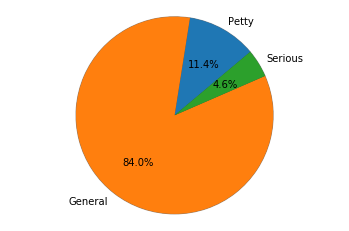

In [0]:
df = pd.DataFrame(explore_b)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
num_incidents = df['num_incidents']
crime_severity = df['crime_severity']

labels = ['Petty', 'General', 'Serious']
sizes = [0, 0, 0]

for i in range(0, len(crime_severity)) :
  if crime_severity[i] == 1 :
    sizes[0] += num_incidents[i]
  elif crime_severity[i] == 9  : 
    sizes[2] += num_incidents[i]
  else : 
    sizes[1] += num_incidents[i]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=(0, 0.1, 0), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=40, radius=100)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### b3) Exploring the relationship between crimes and time of day

In [0]:
%%bigquery --project $project_id explore_b3

SELECT
  CAST(time_in_decimal AS INT64) AS hour_of_day,
  COUNT(CASE
      WHEN crime_severity = 1 THEN 1
  END
    ) AS num_incidents_petty,
  COUNT(CASE
      WHEN crime_severity = 5 THEN 1
  END
    ) AS num_incidents_general,
  COUNT(CASE
      WHEN crime_severity = 9 THEN 1
  END
    ) AS num_incidents_serious
FROM (
  SELECT
    ROUND(CAST(date_trunc_to_hour AS FLOAT64) + CAST(date_trunc_to_min AS FLOAT64) /60, 0) AS time_in_decimal,
    crime_severity
  FROM (
    SELECT
      FORMAT_TIMESTAMP("%H", date) AS date_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", date) AS date_trunc_to_min,
      crime_severity,
      day_of_week
    FROM
      `cs145-leeso.project_3.crimes`) )
GROUP BY
  time_in_decimal
ORDER BY
  time_in_decimal

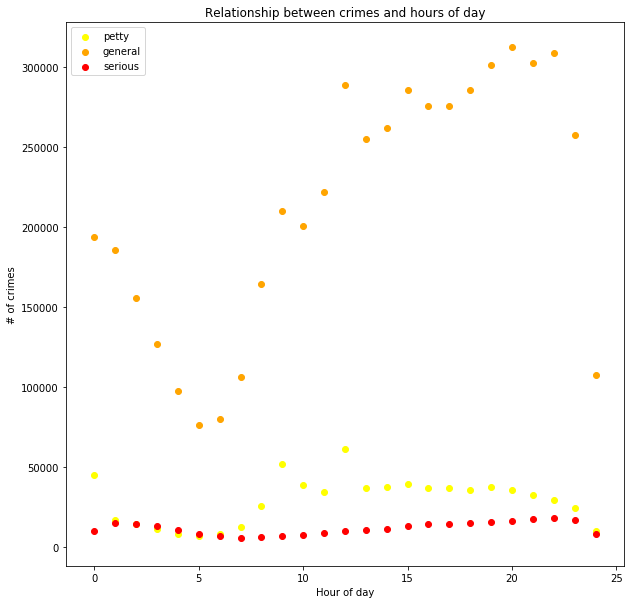

In [0]:
df = pd.DataFrame(explore_b3)
x = df['hour_of_day']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty'],
      df['num_incidents_general'],
      df['num_incidents_serious']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and hours of day")
plt.xlabel("Hour of day")
plt.ylabel("# of crimes")
plt.show()

###b4) Exploring the relationship between crimes and type of location 

In [0]:
%%bigquery --project $project_id explore_b4

select * from (SELECT
  CASE
    WHEN location_description IS NULL THEN 'NO DESCRIPTION'
  ELSE
  location_description
END
  AS location_description,
  ROUND(AVG(crime_severity),2) AS average_severity,
  COUNT(CASE
      WHEN crime_severity = 1 THEN 1
  END
    ) AS num_incidents_petty,
  COUNT(CASE
      WHEN crime_severity = 5 THEN 1
  END
    ) AS num_incidents_general,
  COUNT(CASE
      WHEN crime_severity = 9 THEN 1
  END
    ) AS num_incidents_serious,
  COUNT(*) AS num_incidents_total
FROM
  `cs145-leeso.project_3.crimes`
GROUP BY
  location_description
HAVING
  num_incidents_total >= 100
  AND num_incidents_total <= 175000
ORDER BY
  RAND()
LIMIT 70) order by num_incidents_general+num_incidents_serious DESC

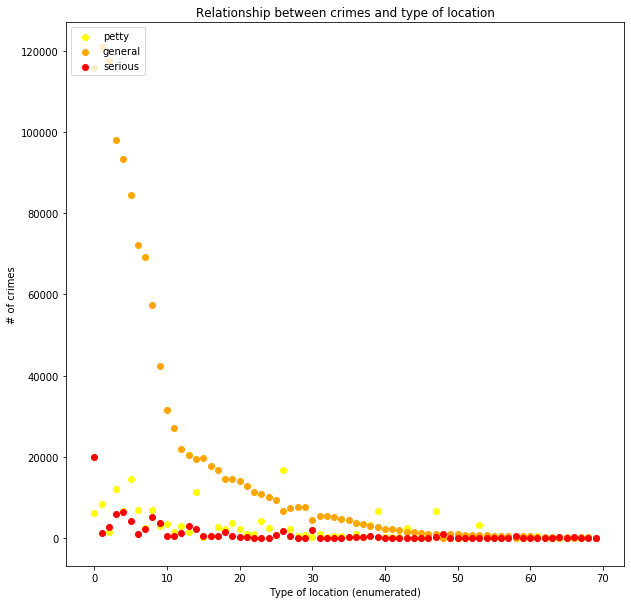

In [0]:
df = pd.DataFrame(explore_b4)
# x = df['location_description']
x = range(0, len(df['location_description']))
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty'],
      df['num_incidents_general'],
      df['num_incidents_serious']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and type of location")
plt.xlabel("Type of location (enumerated)")
plt.ylabel("# of crimes")
plt.show()

###b5) Exploring the relationship between crimes and zipcode

In [0]:
%%bigquery --project $project_id explore_b5

SELECT
  *
FROM (
  SELECT
    zip_code,
    ROUND(AVG(crime_severity),2) AS average_severity,
    COUNT(CASE
        WHEN crime_severity = 1 THEN 1
    END
      ) AS num_incidents_petty,
    COUNT(CASE
        WHEN crime_severity = 5 THEN 1
    END
      ) AS num_incidents_general,
    COUNT(CASE
        WHEN crime_severity = 9 THEN 1
    END
      ) AS num_incidents_serious,
    COUNT(*) AS num_incidents_total
  FROM
    `cs145-leeso.project_3.crimes`
  GROUP BY
    zip_code
  HAVING
    num_incidents_total >= 100
    AND num_incidents_total <= 175000)
ORDER BY
  num_incidents_serious DESC

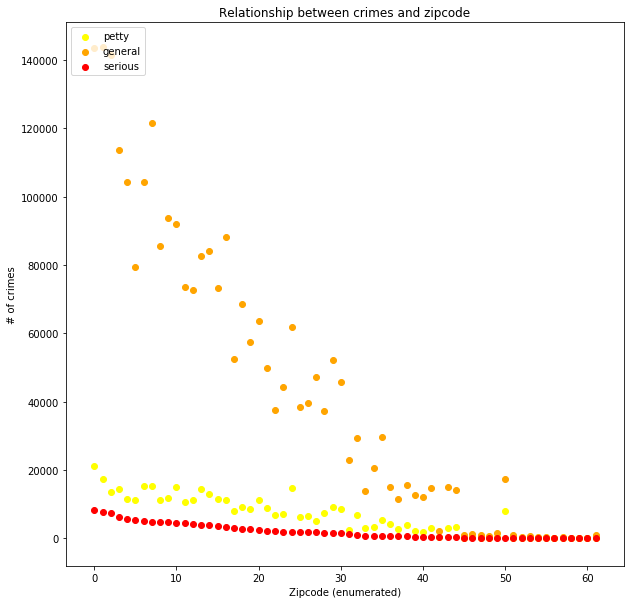

In [0]:
df = pd.DataFrame(explore_b5)
# x = df['location_description']
x = range(0, len(df['zip_code']))
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty'],
      df['num_incidents_general'],
      df['num_incidents_serious']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and zipcode")
plt.xlabel("Zipcode (enumerated)")
plt.ylabel("# of crimes")
plt.show()

###c) Joining crime & census data : ethnographic exploration



In [0]:
%%bigquery --project $project_id explore_c

SELECT
  SUM(num_incidents_petty) AS num_incidents_petty,
  SUM(num_incidents_general) AS num_incidents_general,
  SUM(num_incidents_serious) AS num_incidents_serious,
  SUM(total_pop) AS total_pop,
  ROUND(SUM(num_incidents_petty) / SUM(total_pop), 5) AS num_incidents_petty_per_capita,
  ROUND(SUM(num_incidents_general) / SUM(total_pop), 5) AS num_incidents_general_per_capita,
  ROUND(SUM(num_incidents_serious) / SUM(total_pop), 5) AS num_incidents_serious_per_capita,
  ROUND(SUM(black_pop) / SUM(total_pop) *100, 0) AS black_pop_percentage,
  ROUND(SUM(hispanic_pop) / SUM(total_pop) *100, 0) AS hispanic_pop_percentage,
  ROUND(SUM(white_pop) / SUM(total_pop) *100, 0) AS white_pop_percentage,
  ROUND(SUM(asian_pop) / SUM(total_pop) *100, 0) AS asian_pop_percentage,
  ROUND(SUM(amerindian_pop) / SUM(total_pop) *100, 0) AS amerindian_pop_percentage,
  ROUND(SUM(other_race_pop) / SUM(total_pop) *100, 0) AS other_race_pop_percentage,
  ROUND(SUM(two_or_more_races_pop) / SUM(total_pop) *100, 0) AS two_or_more_races_pop_percentage
FROM (
  SELECT
    *
  FROM (
    SELECT
      zip_code,
      COUNT(CASE
          WHEN crime_severity = 1 THEN 1
      END
        ) AS num_incidents_petty,
      COUNT(CASE
          WHEN crime_severity = 5 THEN 1
      END
        ) AS num_incidents_general,
      COUNT(CASE
          WHEN crime_severity = 9 THEN 1
      END
        ) AS num_incidents_serious
    FROM
      `cs145-leeso.project_3.crimes`
    WHERE
      STRING(date) >= '2008'
      AND STRING(date) <= '2012'
    GROUP BY
      zip_code) serious_crimes,
    `bigquery-public-data.census_bureau_acs.zip_codes_2012_5yr` census_2012
  WHERE
    serious_crimes.zip_code =census_2012.geo_id
    AND census_2012.civilian_labor_force > 2000
  UNION ALL
  SELECT
    *
  FROM (
    SELECT
      zip_code,
      COUNT(CASE
          WHEN crime_severity = 1 THEN 1
      END
        ) AS num_incidents_petty,
      COUNT(CASE
          WHEN crime_severity = 5 THEN 1
      END
        ) AS num_incidents_general,
      COUNT(CASE
          WHEN crime_severity = 9 THEN 1
      END
        ) AS num_incidents_serious
    FROM
      `cs145-leeso.project_3.crimes`
    WHERE
      STRING(date) >= '2013'
      AND STRING(date) <= '2017'
    GROUP BY
      zip_code) serious_crimes,
    `bigquery-public-data.census_bureau_acs.zip_codes_2017_5yr` census_2017
  WHERE
    serious_crimes.zip_code =census_2017.geo_id
    AND census_2017.civilian_labor_force > 2000) crimes_census
GROUP BY
  zip_code
ORDER BY
  num_incidents_serious_per_capita DESC

####c1) Exploring the relationship between occurrence of crimes and population



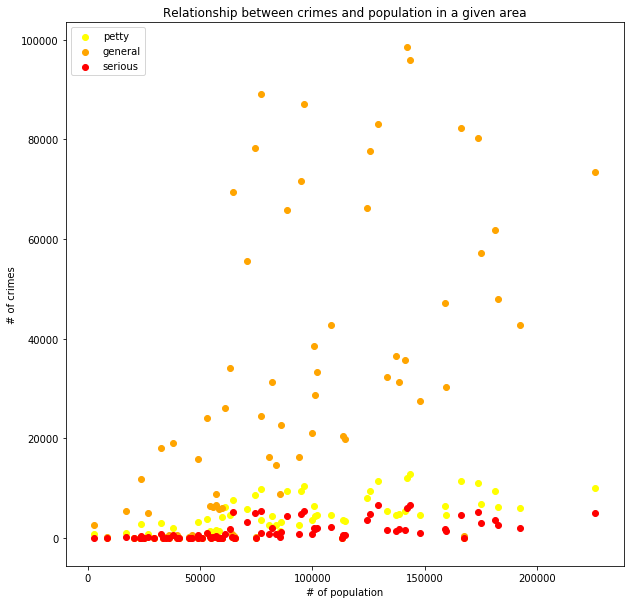

In [0]:
df = pd.DataFrame(explore_c)
x = df['total_pop']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty'],
      df['num_incidents_general'],
      df['num_incidents_serious']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and population in a given area")
plt.xlabel("# of population")
plt.ylabel("# of crimes")
plt.show()

####c2) Exploring the relationship between occurrence of crimes and black population



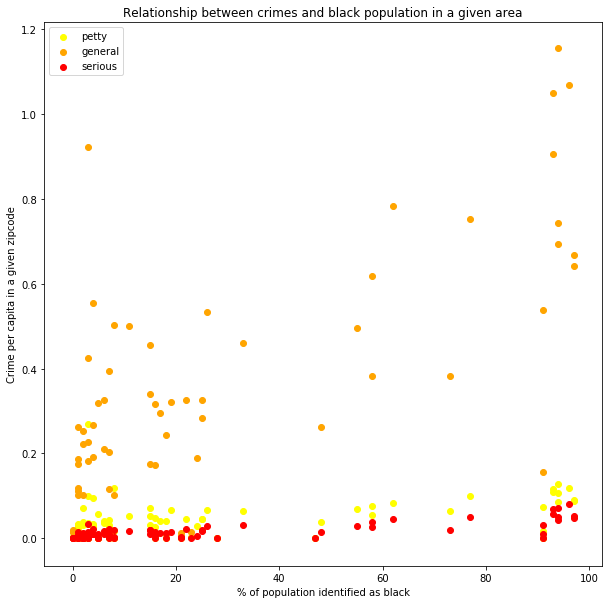

In [0]:
df = pd.DataFrame(explore_c)
x = df['black_pop_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and black population in a given area")
plt.xlabel("% of population identified as black")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####c3) Exploring the relationship between occurrence of crimes and hispanic population



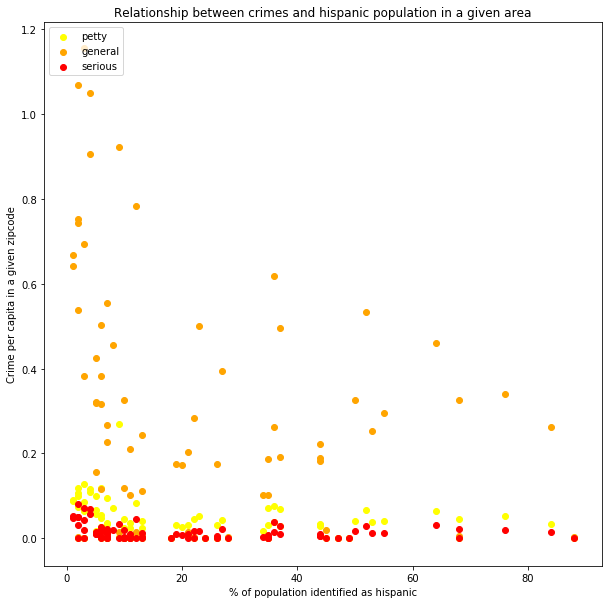

In [0]:
df = pd.DataFrame(explore_c)
x = df['hispanic_pop_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and hispanic population in a given area")
plt.xlabel("% of population identified as hispanic")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####c4) Exploring the relationship between occurrence of crimes and asian population



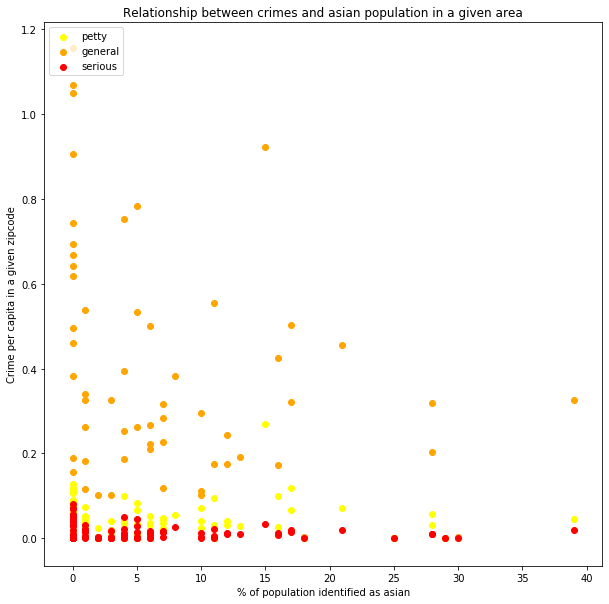

In [0]:
df = pd.DataFrame(explore_c)
x = df['asian_pop_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and asian population in a given area")
plt.xlabel("% of population identified as asian")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####c5) Exploring the relationship between occurrence of crimes and white population



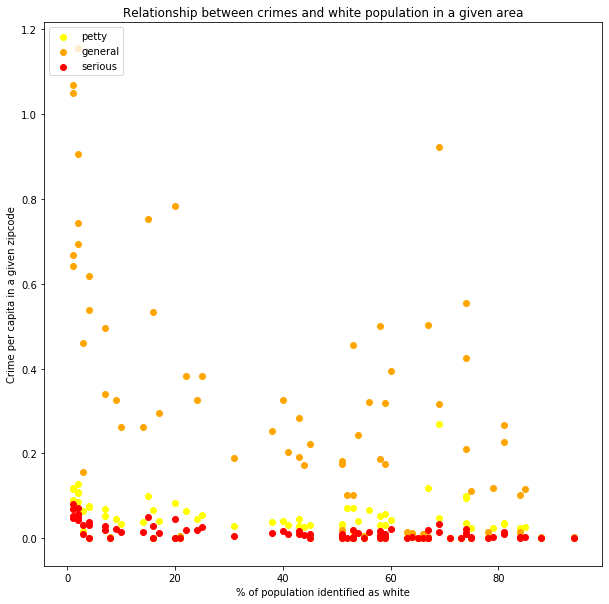

In [0]:
df = pd.DataFrame(explore_c)
x = df['white_pop_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and white population in a given area")
plt.xlabel("% of population identified as white")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

###d) Joining crime & census data : socioeconomic exploration



In [0]:
%%bigquery --project $project_id explore_d

SELECT
  SUM(num_incidents_petty) AS num_incidents_petty,
  SUM(num_incidents_general) AS num_incidents_general,
  SUM(num_incidents_serious) AS num_incidents_serious,
  SUM(total_pop) AS total_pop,
  ROUND(SUM(num_incidents_petty) / SUM(total_pop), 5) AS num_incidents_petty_per_capita,
  ROUND(SUM(num_incidents_general) / SUM(total_pop), 5) AS num_incidents_general_per_capita,
  ROUND(SUM(num_incidents_serious) / SUM(total_pop), 5) AS num_incidents_serious_per_capita,
  ROUND(AVG(percent_income_spent_on_rent),2) AS percent_income_spent_on_rent,
  ROUND(AVG(income_per_capita),2) AS income_per_capita,
  ROUND(AVG(median_income),2) AS median_income,
  ROUND(AVG(median_rent),2) AS median_rent,
  ROUND(AVG(gini_index),2) AS gini_index,
  ROUND(AVG(median_year_structure_built),2) AS median_year_structure_built,
  ROUND(SUM(one_parent_families_with_young_children) / SUM(families_with_young_children)*100,2) AS one_parent_families_percentage,
  ROUND(SUM(households_public_asst_or_food_stamps) / (SUM(nonfamily_households)+SUM(family_households))*100,2) AS food_stamps_households_percentage,
  ROUND(SUM(commuters_by_bus) / SUM(civilian_labor_force)*100,2) AS commuters_by_bus_percentage,
  ROUND(SUM(mortgaged_housing_units) / SUM(housing_units)*100,2) AS mortgaged_housing_units_percentage,
  ROUND(SUM(vacant_housing_units) / SUM(housing_units)*100,2) AS vacant_housing_units_percentage,
  ROUND(SUM(unemployed_pop) / SUM(civilian_labor_force)*100,2) AS unemployed_percentage,
  ROUND(SUM(bachelors_degree_or_higher_25_64) / SUM(pop_25_64)*100,2) AS bachelors_degree_or_higher_25_64_percentage
FROM (
  SELECT
    *
  FROM (
    SELECT
      zip_code,
      COUNT(CASE
          WHEN crime_severity = 1 THEN 1
      END
        ) AS num_incidents_petty,
      COUNT(CASE
          WHEN crime_severity = 5 THEN 1
      END
        ) AS num_incidents_general,
      COUNT(CASE
          WHEN crime_severity = 9 THEN 1
      END
        ) AS num_incidents_serious
    FROM
      `cs145-leeso.project_3.crimes`
    WHERE
      STRING(date) >= '2008'
      AND STRING(date) <= '2012'
    GROUP BY
      zip_code) serious_crimes,
    `bigquery-public-data.census_bureau_acs.zip_codes_2012_5yr` census_2012
  WHERE
    serious_crimes.zip_code =census_2012.geo_id
    AND census_2012.civilian_labor_force > 2000
  UNION ALL
  SELECT
    *
  FROM (
    SELECT
      zip_code,
      COUNT(CASE
          WHEN crime_severity = 1 THEN 1
      END
        ) AS num_incidents_petty,
      COUNT(CASE
          WHEN crime_severity = 5 THEN 1
      END
        ) AS num_incidents_general,
      COUNT(CASE
          WHEN crime_severity = 9 THEN 1
      END
        ) AS num_incidents_serious
    FROM
      `cs145-leeso.project_3.crimes`
    WHERE
      STRING(date) >= '2013'
      AND STRING(date) <= '2017'
    GROUP BY
      zip_code) serious_crimes,
    `bigquery-public-data.census_bureau_acs.zip_codes_2017_5yr` census_2017
  WHERE
    serious_crimes.zip_code =census_2017.geo_id
    AND census_2017.civilian_labor_force > 2000) crimes_census
GROUP BY
  zip_code
HAVING
  num_incidents_serious_per_capita >= 0.001
ORDER BY
  num_incidents_serious_per_capita DESC

####d1) Exploring the relationship between occurrence of crimes and percentage of household income spent on rent



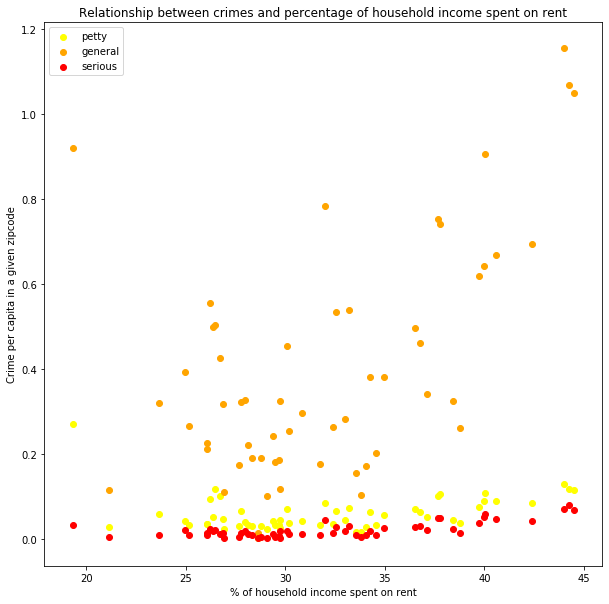

In [0]:
df = pd.DataFrame(explore_d)
x = df['percent_income_spent_on_rent']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and percentage of household income spent on rent")
plt.xlabel("% of household income spent on rent")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d2) Exploring the relationship between occurrence of crimes and percentage of one parent families



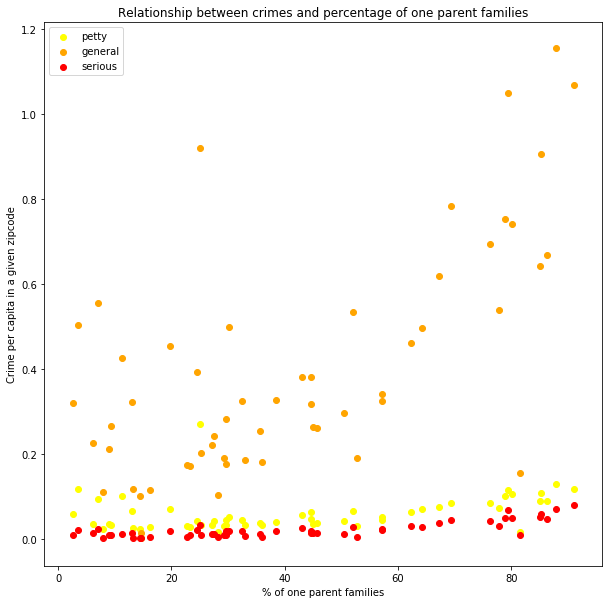

In [0]:
df = pd.DataFrame(explore_d)
x = df['one_parent_families_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and percentage of one parent families")
plt.xlabel("% of one parent families")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d3) Exploring the relationship between occurrence of crimes and percentage of vacant housing units



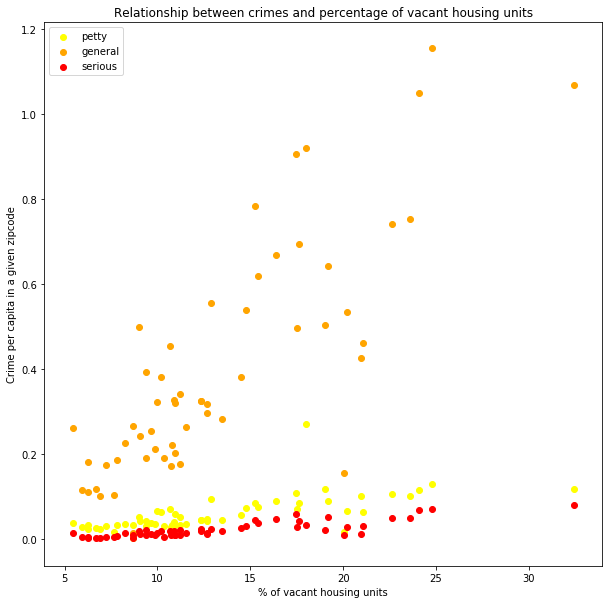

In [0]:
df = pd.DataFrame(explore_d)
x = df['vacant_housing_units_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and percentage of vacant housing units")
plt.xlabel("% of vacant housing units")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d4) Exploring the relationship between occurrence of crimes and unemployment rate



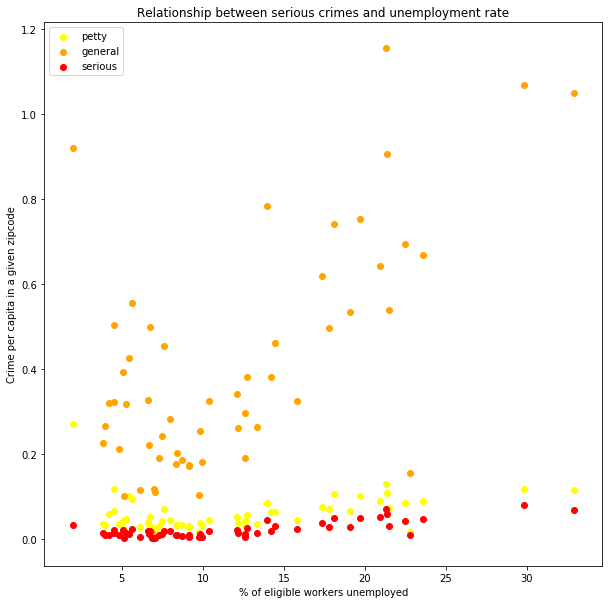

In [0]:
df = pd.DataFrame(explore_d)
x = df['unemployed_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and unemployment rate")
plt.xlabel("% of eligible workers unemployed")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d5) Exploring the relationship between occurrence of crimes and median rent



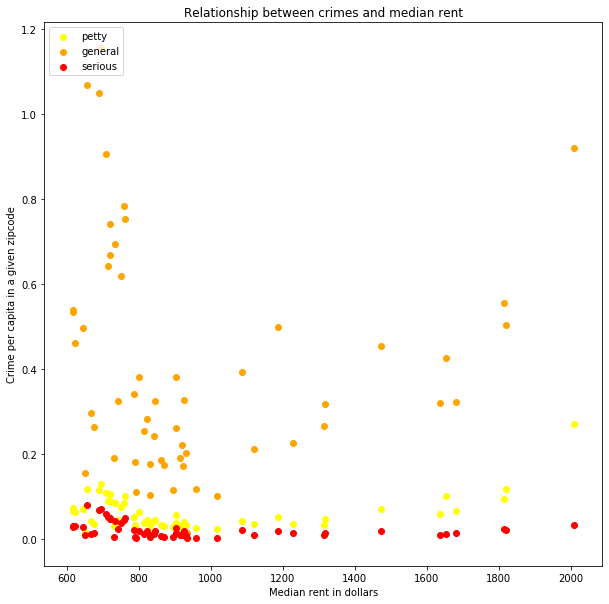

In [0]:
df = pd.DataFrame(explore_d)
x = df['median_rent']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and median rent")
plt.xlabel("Median rent in dollars")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d6) Exploring the relationship between occurrence of crimes and percentage of mortgaged housing units


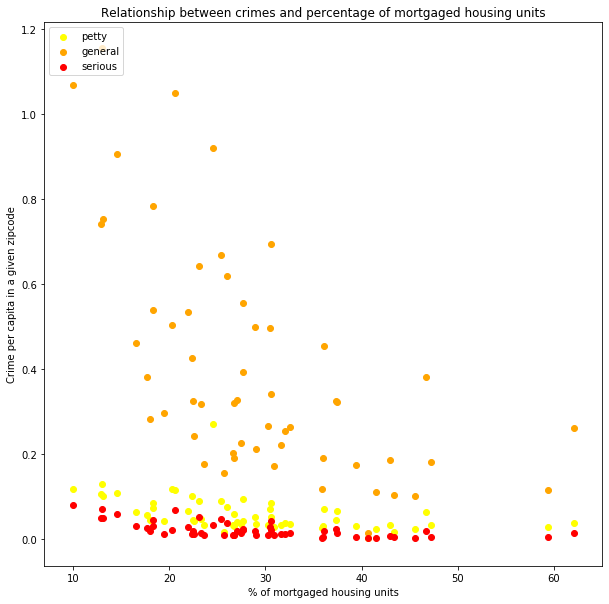

In [0]:
df = pd.DataFrame(explore_d)
x = df['mortgaged_housing_units_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and percentage of mortgaged housing units")
plt.xlabel("% of mortgaged housing units")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d7) Exploring the relationship between occurrence of crimes and degree-holding population


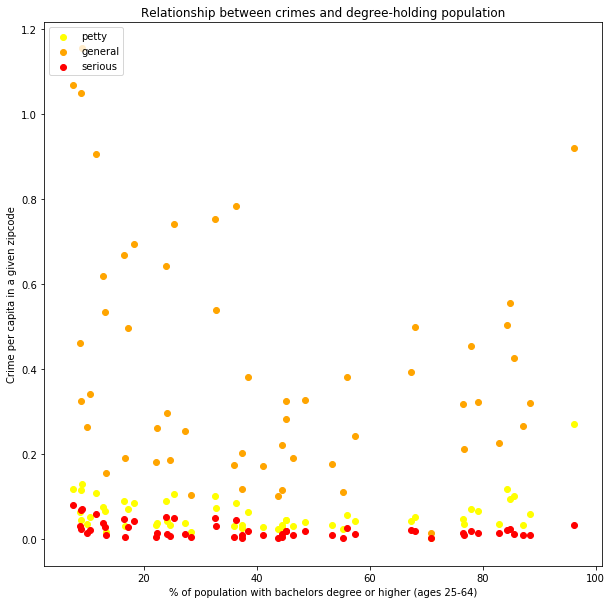

In [0]:
df = pd.DataFrame(explore_d)
x = df['bachelors_degree_or_higher_25_64_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]
colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and degree-holding population")
plt.xlabel("% of population with bachelors degree or higher (ages 25-64)")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d8) Exploring the relationship between crimes and gini index

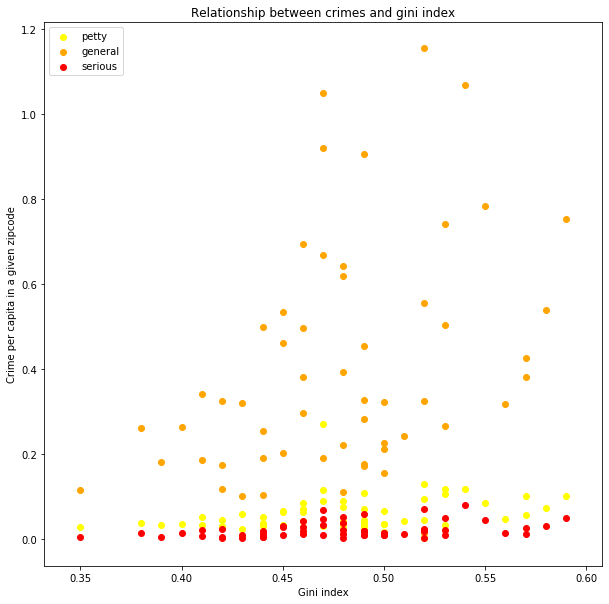

In [0]:
df = pd.DataFrame(explore_d)
x = df['gini_index']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]
colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and gini index")
plt.xlabel("Gini index")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

####d9) Exploring the relationship between crimes and percentage of households receiving food stamps

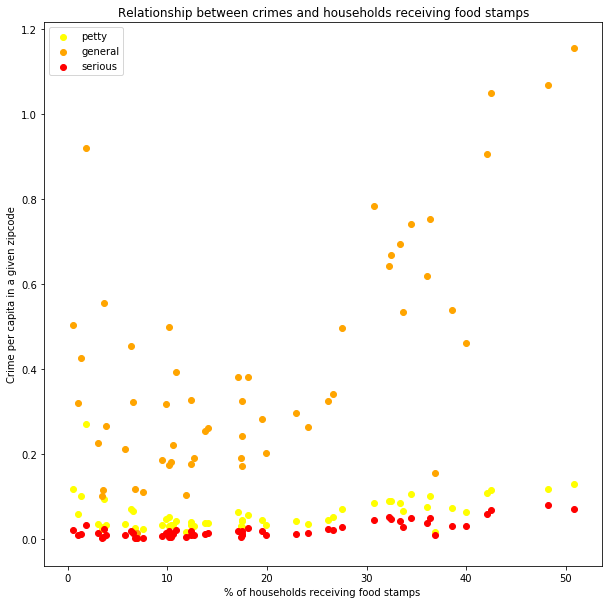

In [0]:
df = pd.DataFrame(explore_d)
x = df['food_stamps_households_percentage']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty_per_capita'],
      df['num_incidents_general_per_capita'],
      df['num_incidents_serious_per_capita']]
colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 10))
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and households receiving food stamps")
plt.xlabel("% of households receiving food stamps ")
plt.ylabel("Crime per capita in a given zipcode")
plt.show()

###e) Joining crime & taxi trips data
The outcome is saved as  `cs145-leeso.project_3.taxi_trips_flux`

In [0]:
%%bigquery --project $project_id
# QUERY SHOWS TOP 10 RESULTS
SELECT
  pickup_zip_code AS trip_zip_code,
  trip_start_date AS trip_date,
  CAST(trip_start_hour AS INT64) AS hour_of_day,
  trip_start_count,
  trip_end_count,
  trip_start_count + trip_end_count AS trip_total_count,
  trip_end_count - trip_start_count AS trip_influx
FROM (
  SELECT
    pickup_zip_code,
    trip_start_date,
    ROUND(CAST(trip_start_trunc_to_hour AS FLOAT64) + CAST(trip_start_trunc_to_min AS FLOAT64) /60, 0) AS trip_start_hour,
    count (*) AS trip_start_count
  FROM (
    SELECT
      pickup_zip_code,
      FORMAT_TIMESTAMP("%D", trip_start_timestamp) AS trip_start_date,
      FORMAT_TIMESTAMP("%H", trip_start_timestamp) AS trip_start_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", trip_start_timestamp) AS trip_start_trunc_to_min
    FROM
      `cs145-leeso.project_3.taxi_trips`)
  GROUP BY
    pickup_zip_code,
    trip_start_date,
    trip_start_hour) trip_start,
  (
  SELECT
    dropoff_zip_code,
    trip_end_date,
    ROUND(CAST(trip_end_trunc_to_hour AS FLOAT64) + CAST(trip_end_trunc_to_min AS FLOAT64) /60, 0) AS trip_end_hour,
    count (*) AS trip_end_count
  FROM (
    SELECT
      dropoff_zip_code,
      FORMAT_TIMESTAMP("%D", trip_end_timestamp) AS trip_end_date,
      FORMAT_TIMESTAMP("%H", trip_end_timestamp) AS trip_end_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", trip_end_timestamp) AS trip_end_trunc_to_min
    FROM (
      SELECT
        trip_start_timestamp,
        trip_end_timestamp,
        trip_seconds,
        trip_miles,
        pickup_community_area,
        dropoff_community_area,
        fare,
        tips,
        tolls,
        trip_total,
        payment_type,
        pickup_zip_code,
        dropoff_zip_code
      FROM (
        SELECT
          taxi_trips.*,
          zip_codes.zip_code AS pickup_zip_code
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips` taxi_trips,
          `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
        WHERE
          pickup_community_area IS NOT NULL
          AND pickup_latitude IS NOT NULL
          AND pickup_longitude IS NOT NULL
          AND ST_WITHIN(ST_GEOGPOINT(taxi_trips.pickup_longitude,
              taxi_trips.pickup_latitude),
            zip_codes.zip_code_geom)) pickup
      INNER JOIN (
        SELECT
          unique_key,
          zip_codes.zip_code AS dropoff_zip_code
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips` taxi_trips,
          `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
        WHERE
          dropoff_community_area IS NOT NULL
          AND dropoff_latitude IS NOT NULL
          AND dropoff_longitude IS NOT NULL
          AND ST_WITHIN(ST_GEOGPOINT(taxi_trips.dropoff_longitude,
              taxi_trips.dropoff_latitude),
            zip_codes.zip_code_geom)) dropoff
      ON
        pickup.unique_key = dropoff.unique_key))
  GROUP BY
    dropoff_zip_code,
    trip_end_date,
    trip_end_hour) trip_end
WHERE
  trip_start.pickup_zip_code = trip_end.dropoff_zip_code
  AND trip_start.trip_start_date = trip_end.trip_end_date
  AND trip_start.trip_start_hour = trip_end.trip_end_hour
ORDER BY
  trip_date,
  trip_zip_code,
  hour_of_day
LIMIT
  10

,trip_zip_code,trip_date,hour_of_day,trip_start_count,trip_end_count,trip_total_count,trip_influx
0,60018,01/01/13,0,5,2,7,-3
1,60018,01/01/13,1,13,7,20,-6
2,60018,01/01/13,2,10,6,16,-4
3,60018,01/01/13,3,3,9,12,6
4,60018,01/01/13,4,1,14,15,13
5,60018,01/01/13,5,2,24,26,22
6,60018,01/01/13,6,11,36,47,25
7,60018,01/01/13,7,11,36,47,25
8,60018,01/01/13,8,7,41,48,34
9,60018,01/01/13,9,30,45,75,15


####e1) Exploring the relationship between time of day, taxi trips, and crime

In [0]:
%%bigquery --project $project_id explore_e3

SELECT
  CAST(trip_start_hour AS INT64) AS hour_of_day,
  trip_start_count,
  trip_end_count,
  trip_start_count + trip_end_count AS trip_total_count
FROM (
  SELECT
    ROUND(CAST(trip_start_trunc_to_hour AS FLOAT64) + CAST(trip_start_trunc_to_min AS FLOAT64) /60, 0) AS trip_start_hour,
    count (*) AS trip_start_count
  FROM (
    SELECT
      FORMAT_TIMESTAMP("%D", trip_start_timestamp) AS trip_start_date,
      FORMAT_TIMESTAMP("%H", trip_start_timestamp) AS trip_start_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", trip_start_timestamp) AS trip_start_trunc_to_min
    FROM
      `cs145-leeso.project_3.taxi_trips`
    ORDER BY
      RAND ( )
    LIMIT
      500000)
  GROUP BY
    trip_start_hour) trip_start,
  (
  SELECT
    ROUND(CAST(trip_end_trunc_to_hour AS FLOAT64) + CAST(trip_end_trunc_to_min AS FLOAT64) /60, 0) AS trip_end_hour,
    count (*) AS trip_end_count
  FROM (
    SELECT
      FORMAT_TIMESTAMP("%D", trip_end_timestamp) AS trip_end_date,
      FORMAT_TIMESTAMP("%H", trip_end_timestamp) AS trip_end_trunc_to_hour,
      FORMAT_TIMESTAMP("%M", trip_end_timestamp) AS trip_end_trunc_to_min
    FROM
      `cs145-leeso.project_3.taxi_trips`
    ORDER BY
      RAND ( )
    LIMIT
      500000)
  GROUP BY
    trip_end_hour) trip_end
WHERE
  trip_start.trip_start_hour = trip_end.trip_end_hour
ORDER BY
  hour_of_day

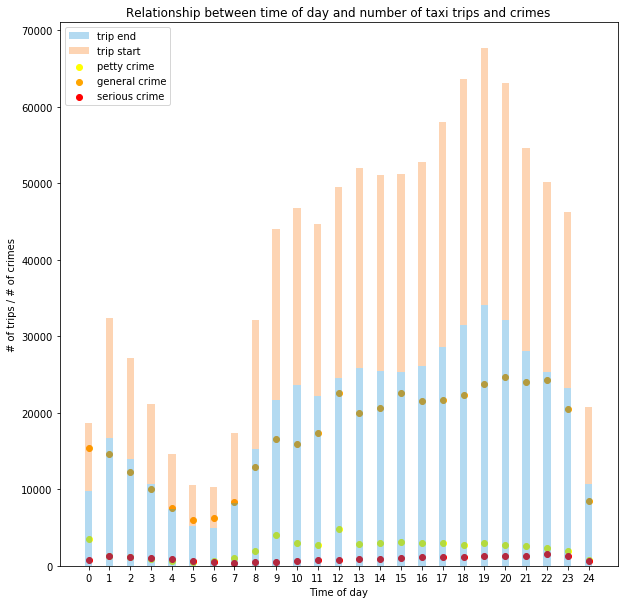

In [0]:
df = pd.DataFrame(explore_e3)
df2 = pd.DataFrame(explore_b3)

stack1 = df['trip_end_count']
stack2 = df['trip_start_count']
xticks = df['hour_of_day']
legend = ('trip end', 'trip start')
ind = np.arange(len(xticks))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(10, 10))

p1 = plt.bar(ind, stack1, width, color= '#0485d1', alpha=0.3)
p2 = plt.bar(ind, stack2, width, color='#f97306',bottom=stack1, alpha = 0.3)

x = df2['hour_of_day']
plots = []
labels = ['petty crime', 'general crime', 'serious crime']
ys = [df2['num_incidents_petty'],
      df2['num_incidents_general'],
      df2['num_incidents_serious']]

colors = ['yellow', 'orange', 'red']
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))

plt.xlabel('Time of day')
plt.ylabel('# of trips / # of crimes')
plt.title('Relationship between time of day and number of taxi trips and crimes')
plt.xticks(ind, xticks)
plt.legend((p1[0], p2[0]), legend)


plt.legend((p1[0], p2[0])+(plots[0], plots[1], plots[2]),
           legend+(labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)

plt.show()

####e2) Exploring the relationship between number of taxi trips in an area and crime

In [0]:
%%bigquery --project $project_id explore_e4

SELECT
  CAST(trip_total_count_rounded AS int64) AS trip_total_count_rounded,
  COUNT(CASE
      WHEN crime_severity = 1 THEN 1
  END
    ) AS num_incidents_petty,
  COUNT(CASE
      WHEN crime_severity = 5 THEN 1
  END
    ) AS num_incidents_general,
  COUNT(CASE
      WHEN crime_severity = 9 THEN 1
  END
    ) AS num_incidents_serious
FROM (
  SELECT
    crimes.*,
    trips.hour_of_day,
    trips.trip_total_count,
    ROUND(trips.trip_total_count,-1) AS trip_total_count_rounded,
    ROUND(trips.trip_influx,-1) AS trip_influx_rounded
  FROM
    `cs145-leeso.project_3.crimes` crimes,
    `cs145-leeso.project_3.taxi_trips_flux` trips
  WHERE
    FORMAT_TIMESTAMP("%D", crimes.date) = trips.trip_date
    AND crimes.zip_code = trips.trip_zip_code
    AND CAST(ROUND(CAST(FORMAT_TIMESTAMP("%H", crimes.date) AS FLOAT64) + CAST(FORMAT_TIMESTAMP("%M", crimes.date) AS FLOAT64) /60, 0) AS INT64) = trips.hour_of_day )
GROUP BY
  trip_total_count_rounded
ORDER BY
  trip_total_count_rounded

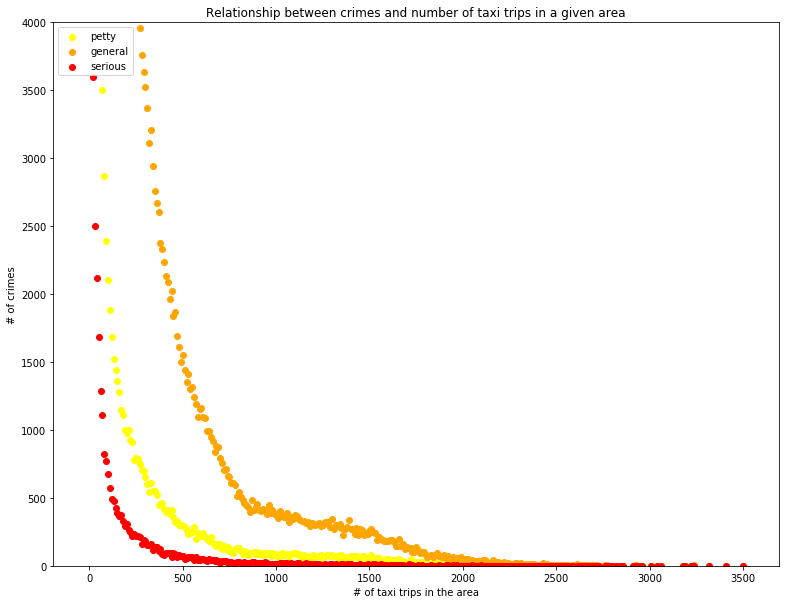

In [0]:
df = pd.DataFrame(explore_e4)
x = df['trip_total_count_rounded']
plots = []
labels = ['petty', 'general', 'serious']
ys = [df['num_incidents_petty'],
      df['num_incidents_general'],
      df['num_incidents_serious']]

colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(13, 10))
plt.ylim(0, 4000)
for y, c in zip(ys, colors):
    plots.append( plt.scatter(x, y, color=c))
plt.legend((plots[0], plots[1], plots[2]),
           (labels[0], labels[1], labels[2]),loc='upper left',
           ncol=1,
           fontsize=10)
plt.title("Relationship between crimes and number of taxi trips in a given area")
plt.xlabel("# of taxi trips in the area")
plt.ylabel("# of crimes")
plt.show()

###Exploration Summary and Analysis

####Existing features
*   `crimes.primary_type`
*   `census.total_pop`
*   `census.gini_index`
*   `census.percent_income_spent_on_rent`
*   `census.median_rent`

####Engineered features
*   `crimes.hour_of_day` Derived from `date`.
*   `census.black_pop_percentage` Calculated by dividing `black_pop` by `total_pop`.
*   `census.white_pop_percentage` Calculated by dividing `white_pop` by `total_pop`.
*   `census.one_parent_families_percentage` Calculated by dividing `one_parent_families_with_young_children` by `families_with_young_children`.
*   `census.vacant_housing_units_percentage` Calculated by dividing `vacant_housing_units` by `housing_units`.
*   `census.unemployed_percentage` Calculated by dividing `employed_pop` by `civilian_labor_force`.
*   `census.food_stamps_households_percentage` Calculated by dividing `households_public_asst_or_food_stamps` by the sum of `nonfamily_households` and `family_households`.
*   `census.mortgaged_housing_units_percentage` Calculated by dividing `mortgaged_housing_units` by `housing_units`.

####Complex Engineered features
*   `crimes.zip_code` Calculated by using BigQuery's Geography functions, checking if a given coordinate lies within a geospatial boundary.
*   `taxi_trips.trip_total_count_rounded`
Calculated by adding the number of pickups and dropoffs, grouped by zipcode and time of day.

####Analysis

*    If a neighborhood has a higher number or general crimes, it almost always has a higher number of both severe and petty crimes.

*    The population of a neighborhood and the number of crimes are not strongly correlated; this may indicate that the number of people living in an area is not a direct factor. It also may show that criminals commit crimes outside of their neighborhoods.

*    We found *very strong* negative correlation between the number of taxis in an area and crime to be surprising because more taxi traffic would suggest more population and activity in a community and thus increased opportunity for unlawful acts. The result may suggest that in general, crimes are more likely to take place in areas less crowded. 

*     The percentage of the black population is shown to be the only contributing feature to the number of crimes in an area; all other ethnicities have negative correlations to the number of unlawful acts.  We will include the feature in our training model, but due to the sensitive nature of the topic, we will not make any further assumptions. (Partially addresses the second supplementary question, *Is the racist opinion that "ethnic minorities" are more dangerous a groundless belief?*)

*      The crime per capita plot pattern for features "percentage of one-parent families," "percentage of households receiving foodstamps," and "% of eligible workers unemployed" are alike. This may indicate that may exist overlap and correlation among the three groups.

*      The correlation between crime per capita in an area and percentage of the population with a bachelor's degree or higher is nearly non-existent.

* Features showing financial difficulties indicate a higher rate of crime in an area. (Answers the third supplementary question, *Does financial hardship cause crimes?*)

* Using the insights gathered we will use the following features to predict `crime_severity`:
  `black_pop_percentage`,
  `white_pop_percentage`,
  `percent_income_spent_on_rent`,
  `median_rent`,
  `gini_index`,
  `one_parent_families_percentage`,
  `food_stamps_households_percentage`,
  `mortgaged_housing_units_percentage`,
  `vacant_housing_units_percentage`,
  `unemployed_percentage`,
  `zip_code`,
  `hour_of_day`,
  `primary_type`,
  `day_of_week`,
  `taxis_in_area`
  

## Data Prediction

### Step 1: Create a dataset to store the model

In [0]:
model_dataset_name = 'project_3_model'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('cs145-leeso', 'project_3_model'))

### Step 2: Extract training data from BigQuery

First, we generate a table with all the crime reports with census data included and severity calculated, then proceed to join the number of taxis in the zip code where the crime occurred.

The difficulty was in joining based on location and time. We convert longitude and latitude into a geometry object and use BigQuery GIS API to check if the location is within a zipcode or zcat. In essence, zcats themselves are also zipcodes, except they are an aggregation of zip codes used by the census. Once longitude and latitude is converted into zcat, equality join based on zcat can be carried out.

In order to join by time (for example, the number of taxis in a zcat at a particular time when at any given time), we used an aggregate array with ORDER BY and LIMIT 1 to find the number of taxis with the closest timestamp at that zip code. This was done because we could not put a subquery into the join since the scoping rules would not allow us to reference one table from another. So 

In [0]:
%%bigquery --project $project_id
  /*Generate `cs145-fa19-254601.CrimeStats.census_crime_taxi`*/
WITH
  census_data AS ( /*Get features from census table as well as zcat*/
  SELECT
    geo_id AS zip_code1,
    SUM(total_pop) AS total_pop,
    ROUND(SUM(black_pop) / SUM(total_pop) *100, 0) AS black_pop_percentage,
    ROUND(SUM(white_pop) / SUM(total_pop) *100, 0) AS white_pop_percentage,
    ROUND(AVG(percent_income_spent_on_rent),2) AS percent_income_spent_on_rent,
    ROUND(AVG(income_per_capita),2) AS income_per_capita,
    ROUND(AVG(median_income),2) AS median_income,
    ROUND(AVG(median_rent),2) AS median_rent,
    ROUND(AVG(gini_index),2) AS gini_index,
    ROUND(AVG(median_year_structure_built),2) AS median_year_structure_built,
    ROUND(SUM(one_parent_families_with_young_children) / SUM(families_with_young_children)*100,2) AS one_parent_families_percentage,
    ROUND(SUM(households_public_asst_or_food_stamps) / (SUM(nonfamily_households)+SUM(family_households))*100,2) AS food_stamps_households_percentage,
    ROUND(SUM(commuters_by_bus) / SUM(civilian_labor_force)*100,2) AS commuters_by_bus_percentage,
    ROUND(SUM(mortgaged_housing_units) / SUM(housing_units)*100,2) AS mortgaged_housing_units_percentage,
    ROUND(SUM(vacant_housing_units) / SUM(housing_units)*100,2) AS vacant_housing_units_percentage,
    ROUND(SUM(unemployed_pop) / SUM(civilian_labor_force)*100,2) AS unemployed_percentage,
    ROUND(SUM(bachelors_degree_or_higher_25_64) / SUM(pop_25_64)*100,2) AS bachelors_degree_or_higher_25_64_percentage
  FROM
    `bigquery-public-data.census_bureau_acs.zip_codes_2013_5yr` census_2013
  WHERE
    total_pop > 0
    AND families_with_young_children > 0
    AND civilian_labor_force > 0
    AND housing_units > 0
    AND pop_25_64 > 0
  GROUP BY
    geo_id ),
  crimes AS ( /*Get crimes data and convert long,lat to zcat. Group crimes into severity, filter before 2013 because taxis data only >2013*/
  SELECT
    crimes.*,
    zip_codes.zip_code AS zip_code2,
    CASE
      WHEN primary_type = 'CRIM SEXUAL ASSAULT' OR primary_type = 'ROBBERY' OR primary_type = 'ARSON' OR primary_type = 'HOMICIDE' OR primary_type = 'KIDNAPPING' OR primary_type = 'HUMAN TRAFFICKING' THEN 9
      WHEN primary_type = 'OTHER OFFENSE'
    OR primary_type = 'DECEPTIVE PRACTICE'
    OR primary_type = 'PUBLIC PEACE VIOLATION'
    OR primary_type = 'GAMBLING'
    OR primary_type = 'LIQUOR LAW VIOLATION'
    OR primary_type = 'INTIMIDATION'
    OR primary_type = 'OBSCENITY' THEN 1
    ELSE
    5
  END
    AS crime_severity
  FROM
    `bigquery-public-data.chicago_crime.crime` crimes,
    `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
  WHERE
    community_area IS NOT NULL
    AND latitude IS NOT NULL
    AND longitude IS NOT NULL
    AND ST_WITHIN(ST_GEOGPOINT(crimes.longitude,
        crimes.latitude),
      zip_codes.zip_code_geom)
    AND year >= 2013
    AND year <= 2017),
  taxis AS (
  WITH
    taxi1 AS ( /*Count taxis picking up in a zcat*/
    SELECT
      taxi_id AS id,
      trip_start_timestamp AS time,
      zip.zip_code AS zip
    FROM
      `bigquery-public-data.chicago_taxi_trips.taxi_trips` t1,
      `bigquery-public-data.geo_us_boundaries.zip_codes` zip
    WHERE
      ST_WITHIN(ST_GEOGPOINT(t1.pickup_longitude,
          t1.pickup_latitude),
        zip.zip_code_geom)
    UNION ALL
      /*Count taxis dropping off in a zcat*/
    SELECT
      taxi_id AS id,
      trip_end_timestamp AS time,
      zip.zip_code AS zip
    FROM
      `bigquery-public-data.chicago_taxi_trips.taxi_trips` t1,
      `bigquery-public-data.geo_us_boundaries.zip_codes` zip
    WHERE
      ST_WITHIN(ST_GEOGPOINT(t1.dropoff_longitude,
          t1.dropoff_latitude),
        zip.zip_code_geom))
  SELECT
    zip,
    time,
    FORMAT_TIMESTAMP("%D", time) AS date,
    FORMAT_TIMESTAMP("%H", time) AS hour,
    COUNT(DISTINCT(id)) AS num_taxis
  FROM
    taxi1
  GROUP BY
    time,
    date,
    hour,
    zip
  ORDER BY
    time,
    date,
    hour),
  census_crimes AS ( /*Join census table with crimes table using zcat*/
  SELECT
    census_data.*,
    crimes.*
  FROM
    census_data,
    crimes
  WHERE
    census_data.zip_code1 = crimes.zip_code2 ),
  crimes_taxi AS ( /*Join crimes table with taxis table using zcat and nearest time stamp*/
  SELECT
    a.case_number,
    ARRAY_AGG( b.num_taxis
    ORDER BY
      ABS(TIMESTAMP_DIFF(b.time,a.date,MINUTE)) ASC
    LIMIT
      1) AS num_taxis
  FROM
    census_crimes a,
    taxis b
  WHERE
    a.zip_code1 = b.zip
  GROUP BY
    case_number) /*Join census-crimes and crimes-taxi tables*/
SELECT
  a.*,
  b.num_taxis[
OFFSET
  (0)] AS num_taxis
FROM
  census_crimes a,
  crimes_taxi b
WHERE
  a.case_number = b.case_number
LIMIT 10

,zip_code1,total_pop,black_pop_percentage,white_pop_percentage,percent_income_spent_on_rent,income_per_capita,median_income,median_rent,gini_index,median_year_structure_built,one_parent_families_percentage,food_stamps_households_percentage,commuters_by_bus_percentage,mortgaged_housing_units_percentage,vacant_housing_units_percentage,unemployed_percentage,bachelors_degree_or_higher_25_64_percentage,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,zip_code2,crime_severity,num_taxis,time_err
0,60656,26896.0,1.0,80.0,26.8,34646.0,60575.0,977.0,0.43,1963.0,13.13,9.01,1.82,33.20,7.25,5.61,42.93,10446135,HZ184863,2016-03-12 18:00:00+00:00,052XX N OAK PARK AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,PARK PROPERTY,False,False,1613,16,41,10,14,1130264.0,1934367.0,2016,2018-02-10 15:50:01+00:00,41.976179,-87.796348,"(41.976178538, -87.796348413)",60656,5,1,15
1,60656,26896.0,1.0,80.0,26.8,34646.0,60575.0,977.0,0.43,1963.0,13.13,9.01,1.82,33.20,7.25,5.61,42.93,10379457,HZ115300,2016-01-14 12:30:00+00:00,085XX W SUNNYSIDE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,1614,16,36,76,08B,1118289.0,1928872.0,2016,2018-02-10 15:50:01+00:00,41.961297,-87.840503,"(41.96129713, -87.840502582)",60656,5,2,15
2,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,10459770,HZ198932,2016-03-24 01:50:00+00:00,033XX W 111TH ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2211,22,19,74,08B,1156239.0,1830812.0,2016,2018-02-10 15:50:01+00:00,41.691525,-87.703619,"(41.691524515, -87.703618876)",60655,5,1,20
3,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,9590446,HX240823,2014-04-25 23:59:00+00:00,109XX S TROY ST,1780,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,RESIDENCE,False,True,2211,22,19,74,26,1157301.0,1831846.0,2014,2016-02-04 06:33:39+00:00,41.694341,-87.699703,"(41.694340635, -87.699702887)",60655,5,1,29
4,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,9615210,HX264756,2014-05-17 00:20:00+00:00,033XX W 114TH ST,4387,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,RESIDENCE,True,True,2211,22,19,74,26,1156139.0,1828995.0,2014,2018-02-10 15:50:01+00:00,41.686540,-87.704034,"(41.686540325, -87.704033587)",60655,1,1,25
5,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,9259853,HW404946,2013-08-12 17:55:00+00:00,108XX S TROY ST,0460,BATTERY,SIMPLE,RESIDENCE,False,False,2211,22,19,74,08B,1157264.0,1832601.0,2013,2018-02-10 15:50:01+00:00,41.696413,-87.699818,"(41.696413242, -87.699818024)",60655,5,1,5
6,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,10904494,JA216371,2017-04-06 19:30:00+00:00,112XX S CAMPBELL AVE,1780,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,RESIDENCE,False,True,2212,22,19,75,20,1161721.0,1830020.0,2017,2018-02-10 15:50:01+00:00,41.689239,-87.683570,"(41.689239398, -87.68357037)",60655,5,1,0
7,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,9287325,HW431715,2013-08-29 09:00:00+00:00,104XX S SPAULDING AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,2211,22,19,74,26,1156185.0,1835235.0,2013,2018-02-10 15:50:01+00:00,41.703663,-87.703698,"(41.703663139, -87.7036982)",60655,1,1,0
8,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,9673621,HX323792,2014-06-29 13:20:00+00:00,039XX W 103RD ST,1330,CRIMINAL TRESPASS,TO LAND,DRUG STORE,True,False,2211,22,19,74,26,1151669.0,1836013.0,2014,2018-02-10 15:50:01+00:00,41.705888,-87.720215,"(41.705887536, -87.720214826)",60655,5,1,5
9,60655,28972.0,7.0,83.0,23.2,38002.0,94524.0,943.0,0.36,1954.0,18.04,3.80,1.49,57.61,6.08,3.92,45.82,9900174,HX550889,2014-12-21 19:00:0

### Step 3: Train the model

In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  `cs145-leeso.project_3_model.model` OPTIONS(model_type='logistic_reg') AS
SELECT
  crime_severity as label,
  total_pop,
  black_pop_percentage,
  white_pop_percentage,
  percent_income_spent_on_rent,
  median_rent,
  gini_index,
  one_parent_families_percentage,
  food_stamps_households_percentage,
  mortgaged_housing_units_percentage,
  vacant_housing_units_percentage,
  unemployed_percentage,
  zip_code,
  hour_of_day,
  primary_type,
  day_of_week,
  taxis_in_area
FROM
  `cs145-leeso.project_3.extract` data
WHERE
  PARSE_DATETIME('%m/%d/%y', date) >= PARSE_DATETIME('%m/%d/%y', '01/01/13')
  AND
  PARSE_DATETIME('%m/%d/%y', date) <= PARSE_DATETIME('%m/%d/%y', '12/31/15')

### Step 4: Evaluate

In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-leeso.project_3_model.model`,
    (
    SELECT
      crime_severity AS label,
      total_pop,
      black_pop_percentage,
      white_pop_percentage,
      percent_income_spent_on_rent,
      median_rent,
      gini_index,
      one_parent_families_percentage,
      food_stamps_households_percentage,
      mortgaged_housing_units_percentage,
      vacant_housing_units_percentage,
      unemployed_percentage,
      zip_code,
      hour_of_day,
      day_of_week,
      taxis_in_area,
      location_description
    FROM
      `cs145-leeso.project_3.extract` data
    WHERE
      PARSE_DATETIME('%m/%d/%y',
        date) >= PARSE_DATETIME('%m/%d/%y',
        '01/01/16')))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.849359,0.360603,0.8079,0.350125,1.087047,0.728208


### Step 5: Re-train the model

The number of general crimes is much larger than the number of serious or petty crimes, so the machine learning model tends to classify most crimes as general. Ironically, this undesirable approach results in the accuracy being quite high (around 0.8.) To get around this, we resample the general crimes so that the total number of general crimes is similar to the number of crimes in the other categories.

In [0]:
%%bigquery --project $project_id
/*Generate `cs145-fa19-254601.CrimeStats.census_crime_taxi2` with fewer crimes in general category so crimes more evenly distributed*/

WITH general AS (SELECT * FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` WHERE crime_severity = 5),
sampled AS (
select d.* EXCEPT (seqnum,cnt)
from (select a.*,
             row_number() over (order by unique_key) as seqnum,
             count(*) over () as cnt
      from general a
     ) d
where MOD(seqnum, 5) = 1),
Other_crimes AS (SELECT * FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` WHERE crime_severity != 5), 
Recombined AS (SELECT * FROM Other_crimes UNION ALL (SELECT * FROM sampled))
SELECT * FROM Recombined 

In [0]:
%%bigquery --project $project_id predict_crimes

CREATE OR REPLACE MODEL
  `cs145-fa19-254601.project_3_model.model` OPTIONS(model_type='logistic_reg') AS
SELECT
  crime_severity as label,
  total_pop as feature1,
  black_pop_percentage as feature2,
  white_pop_percentage as feature3,
  percent_income_spent_on_rent as feature4,
  median_rent as feature5,
  gini_index as feature6,
  one_parent_families_percentage as feature7,
  food_stamps_households_percentage as feature8,
  mortgaged_housing_units_percentage as feature9,
  vacant_housing_units_percentage as feature10,
  unemployed_percentage as feature11,
  zip_code1 as feature12,
  EXTRACT(HOUR FROM date) as feature13,
  #primary_type as feature14,
  EXTRACT(DAYOFWEEK FROM DATE(date)) as feature15,
  num_taxis as feature16
FROM
  `cs145-fa19-254601.CrimeStats.census_crime_taxi2` data
WHERE
  date >= TIMESTAMP('2013-01-01 00:00:00')
  AND
  date <= TIMESTAMP('2015-12-31 23:59:59')

In [0]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-fa19-254601.project_3_model.model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,4,0.326432,0.327529,0.8,37735
1,0,3,0.326741,0.327689,1.6,35438
2,0,2,0.332648,0.333176,0.8,32396
3,0,1,0.344686,0.344795,0.4,36392
4,0,0,0.356968,0.356954,0.2,25887


###Step 6: Re-evaluate

In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-fa19-254601.project_3_model.model`,
    (
    SELECT
      crime_severity as label,
      total_pop as feature1,
      black_pop_percentage as feature2,
      white_pop_percentage as feature3,
      percent_income_spent_on_rent as feature4,
      median_rent as feature5,
      gini_index as feature6,
      one_parent_families_percentage as feature7,
      food_stamps_households_percentage as feature8,
      mortgaged_housing_units_percentage as feature9,
      vacant_housing_units_percentage as feature10,
      unemployed_percentage as feature11,
      zip_code1 as feature12,
      EXTRACT(HOUR FROM date) as feature13,
      #primary_type as feature14,
      EXTRACT(DAYOFWEEK FROM DATE(date)) as feature15,
      num_taxis as feature16
    FROM
      `cs145-fa19-254601.CrimeStats.census_crime_taxi2` data
    WHERE
      date > TIMESTAMP('2015-12-31 23:59:59') AND 
      date < TIMESTAMP('2016-12-31 23:59:59')
        ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.328187,0.341268,0.457896,0.241968,1.101695,0.556643


### Step 7: Predict

In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.PREDICT(MODEL `cs145-fa19-254601.project_3_model.model`,
    (
    SELECT
      crime_severity as label,
      total_pop as feature1,
      black_pop_percentage as feature2,
      white_pop_percentage as feature3,
      percent_income_spent_on_rent as feature4,
      median_rent as feature5,
      gini_index as feature6,
      one_parent_families_percentage as feature7,
      food_stamps_households_percentage as feature8,
      mortgaged_housing_units_percentage as feature9,
      vacant_housing_units_percentage as feature10,
      unemployed_percentage as feature11,
      zip_code1 as feature12,
      EXTRACT(HOUR FROM date) as feature13,
      #primary_type as feature14,
      EXTRACT(DAYOFWEEK FROM DATE(date)) as feature15,
      num_taxis as feature16
    FROM
      `cs145-fa19-254601.CrimeStats.census_crime_taxi2` data
    WHERE
      date >= TIMESTAMP('2016-12-31 23:59:59') 
        ))

,predicted_label,predicted_label_probs,label,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature15,feature16
0,1,"[{'label': 1, 'prob': 0.37829972074827933}, {'...",1,28899.0,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,60631,9,1,4
1,1,"[{'label': 1, 'prob': 0.3749006338101752}, {'l...",1,28899.0,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,60631,16,4,4
2,1,"[{'label': 1, 'prob': 0.3819528744331514}, {'l...",9,28899.0,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,60631,3,5,1
3,1,"[{'label': 1, 'prob': 0.38185933786696835}, {'...",9,28314.0,1.0,76.0,26.0,761.0,0.49,8.67,7.19,40.87,6.81,8.35,60646,0,1,2
4,5,"[{'label': 5, 'prob': 0.3549669843255495}, {'l...",1,33608.0,96.0,1.0,46.8,676.0,0.54,92.50,47.51,11.70,32.47,33.84,60621,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92253,5,"[{'label': 5, 'prob': 0.36612705391146105}, {'...",1,33608.0,96.0,1.0,46.8,676.0,0.54,92.50,47.51,11.70,32.47,33.84,60621,15,4,1
92254,5,"[{'label': 5, 'prob': 0.3543351629036365}, {'l...",9,33608.0,96.0,1.0,46.8,676.0,0.54,92.50,47.51,11.70,32.47,33.84,60621,0,5,1
92255,5,"[{'label': 5, 'prob': 0.35789805276896774}, {'...",9,33608.0,96.0,1.0,46.8,676.0,0.54,92.50,47.51,11.70,32.47,33.84,60621,5,7,1
92256,5,"[{'label': 5, 'prob': 0.3659692734577606}, {'l...",1,33608.0,96.0,1.0,46.8,676.0,0.54,92.50,47.51,11.70,32.47,33.84,60621,15,5,1


In [0]:
%%bigquery --project $project_id predict_severity

SELECT
COUNT(CASE
      WHEN label = 1 THEN 1
  END
    ) AS actual_petty, COUNT(CASE
      WHEN label = 5 THEN 1
  END
    ) AS actual_general, COUNT(CASE
      WHEN label = 9 THEN 1
  END
    ) AS actual_serious,
  COUNT(CASE
      WHEN predicted_label = 1 THEN 1
  END
    ) AS predicted_petty, COUNT(CASE
      WHEN predicted_label = 5 THEN 1
  END
    ) AS predicted_general, COUNT(CASE
      WHEN predicted_label = 9 THEN 1
  END
    ) AS predicted_serious,
  feature1 AS total_pop, feature2 AS black_pop_percentage, 
  feature3 AS white_pop_percentage, feature4 AS percent_income_spent_on_rent, feature5 AS median_rent, feature6 AS gini_index,
  feature7 AS one_parent_families_percentage, feature8 AS food_stamps_households_percentage, feature9 AS mortgaged_housing_units_percentage,
  feature10 AS vacant_housing_units_percentage, feature11 AS unemployed_percentage, feature12 AS zip_code1, feature13 AS hour, 
  feature15 AS day_of_week, feature16 AS num_taxis
FROM
  ML.PREDICT(MODEL `cs145-fa19-254601.project_3_model.model`,
    (
    SELECT
      crime_severity as label,
      total_pop as feature1,
      black_pop_percentage as feature2,
      white_pop_percentage as feature3,
      percent_income_spent_on_rent as feature4,
      median_rent as feature5,
      gini_index as feature6,
      one_parent_families_percentage as feature7,
      food_stamps_households_percentage as feature8,
      mortgaged_housing_units_percentage as feature9,
      vacant_housing_units_percentage as feature10,
      unemployed_percentage as feature11,
      zip_code1 as feature12,
      EXTRACT(HOUR FROM date) as feature13,
      #primary_type as feature14,
      EXTRACT(DAYOFWEEK FROM DATE(date)) as feature15,
      num_taxis as feature16
    FROM
      `cs145-fa19-254601.CrimeStats.census_crime_taxi2` data
    WHERE
      date >= TIMESTAMP('2016-12-31 23:59:59') 
        ))
 GROUP BY  total_pop, black_pop_percentage, 
 white_pop_percentage, percent_income_spent_on_rent, median_rent, gini_index,
  one_parent_families_percentage, food_stamps_households_percentage, mortgaged_housing_units_percentage,
  vacant_housing_units_percentage, unemployed_percentage, zip_code1, hour, 
  day_of_week, num_taxis

Text(0, 0.5, 'Number of Crimes')

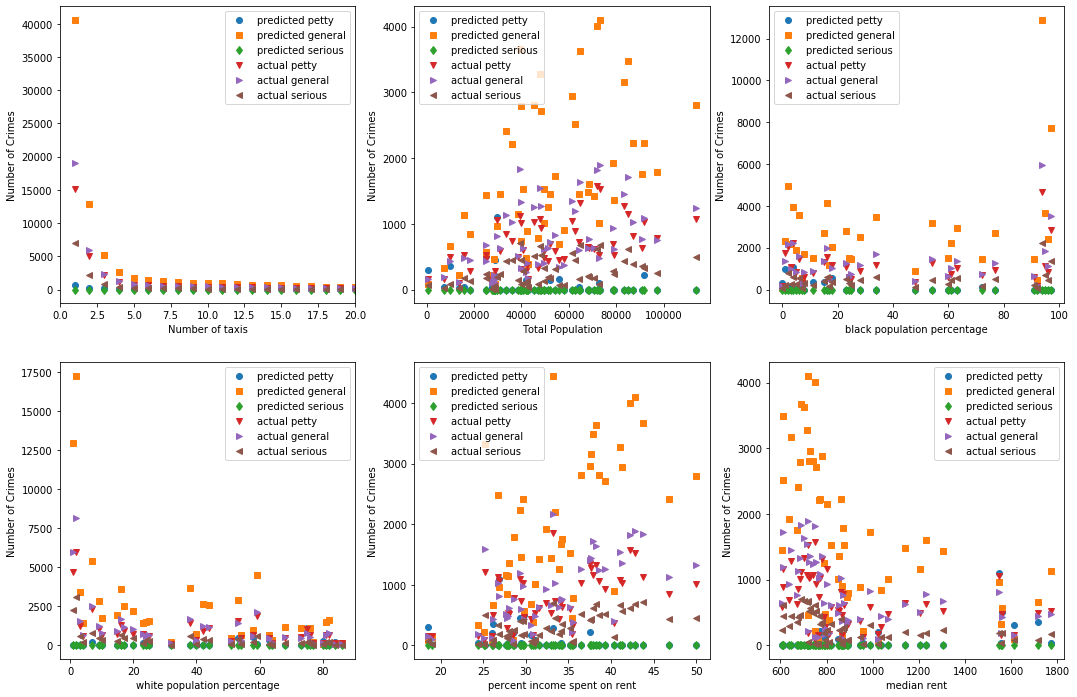

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(predict_severity)
df1 = df.groupby('num_taxis').sum().reset_index()
#print(df)
x = df1['num_taxis']

plt.figure(figsize=(18, 12))
plt.subplot(231)
df1 = df.groupby('num_taxis').sum().reset_index()
x = df1['num_taxis']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
plt.xlim(0,20)
plt.xlabel('Number of taxis')
plt.ylabel('Number of Crimes')
plt.subplot(232)
df1 = df.groupby('total_pop').sum().reset_index()
x = df1['total_pop']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Total Population')
plt.ylabel('Number of Crimes')
plt.subplot(233)
df1 = df.groupby('black_pop_percentage').sum().reset_index()
x = df1['black_pop_percentage']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('black population percentage')
plt.ylabel('Number of Crimes')
plt.subplot(234)
df1 = df.groupby('white_pop_percentage').sum().reset_index()
x = df1['white_pop_percentage']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('white population percentage')
plt.ylabel('Number of Crimes')
plt.subplot(235)
df1 = df.groupby('percent_income_spent_on_rent').sum().reset_index()
x = df1['percent_income_spent_on_rent']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('percent income spent on rent')
plt.ylabel('Number of Crimes')
plt.subplot(236)
df1 = df.groupby('median_rent').sum().reset_index()
x = df1['median_rent']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('median rent')
plt.ylabel('Number of Crimes')


Text(0, 0.5, 'Number of Crimes')

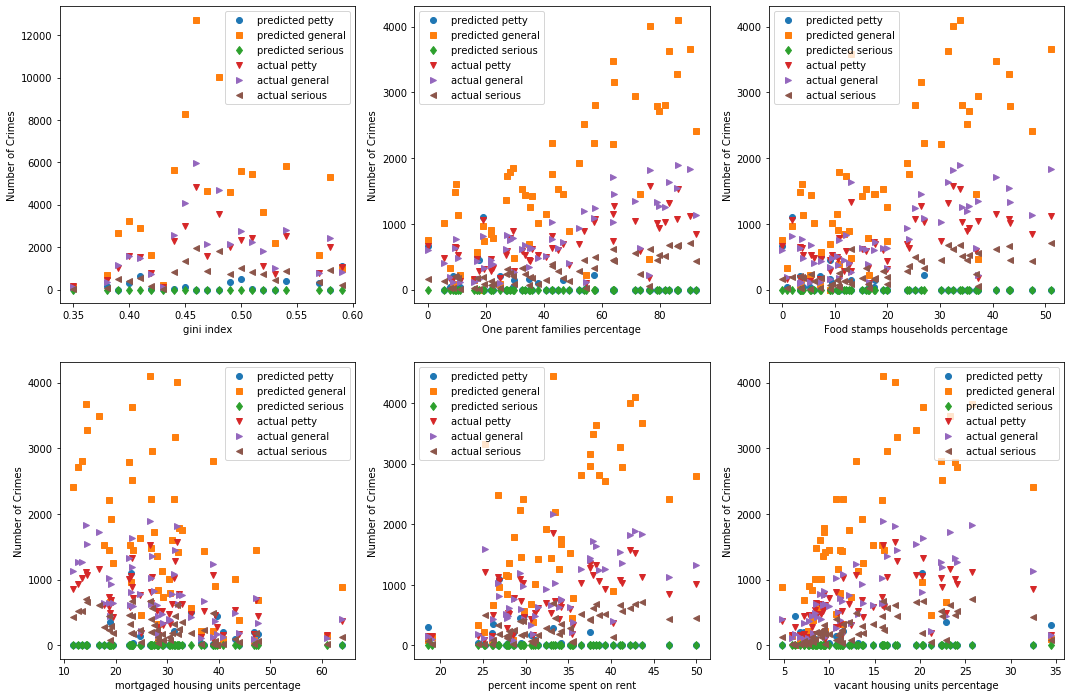

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(predict_severity)
df1 = df.groupby('num_taxis').sum().reset_index()
#print(df)
x = df1['num_taxis']

plt.figure(figsize=(18, 12))
plt.subplot(231)
df1 = df.groupby('gini_index').sum().reset_index()
x = df1['gini_index']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('gini index')
plt.ylabel('Number of Crimes')
plt.subplot(232)
df1 = df.groupby('one_parent_families_percentage').sum().reset_index()
x = df1['one_parent_families_percentage']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('One parent families percentage')
plt.ylabel('Number of Crimes')
plt.subplot(233)
df1 = df.groupby('food_stamps_households_percentage').sum().reset_index()
x = df1['food_stamps_households_percentage']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Food stamps households percentage')
plt.ylabel('Number of Crimes')
plt.subplot(234)
df1 = df.groupby('mortgaged_housing_units_percentage').sum().reset_index()
x = df1['mortgaged_housing_units_percentage']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('mortgaged housing units percentage')
plt.ylabel('Number of Crimes')
plt.subplot(235)
df1 = df.groupby('percent_income_spent_on_rent').sum().reset_index()
x = df1['percent_income_spent_on_rent']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('percent income spent on rent')
plt.ylabel('Number of Crimes')
plt.subplot(236)
df1 = df.groupby('vacant_housing_units_percentage').sum().reset_index()
x = df1['vacant_housing_units_percentage']
plt.plot(x,df1['predicted_petty'],'o',label='predicted petty')
plt.plot(x,df1['predicted_general'],'s',label='predicted general')
plt.plot(x,df1['predicted_serious'],'d',label='predicted serious')
plt.plot(x,df1['actual_petty'],'v',label='actual petty')
plt.plot(x,df1['actual_general'],'>',label='actual general')
plt.plot(x,df1['actual_serious'],'<',label='actual serious')
plt.legend()
#plt.xlim(0,20)
plt.xlabel('vacant housing units percentage')
plt.ylabel('Number of Crimes')


We can see the main issue is that the model rarely classifies a crime as serious, this is because even after we make the distribution more even the number of serious crimes is still much less than the number of general and petty crimes in the training data set

## (Extra) Prediction of number of crimes

In this alternative version of data prediction, we will ignore the gravity of crimes. The following steps construct a different model using the same data set used in the previous prediction.

###Step 1: Train the model


In [0]:
%%bigquery --project $project_id predict_crimes

CREATE OR REPLACE MODEL
  `cs145-fa19-254601.project_3_model.model2` OPTIONS(model_type='linear_reg',input_label_cols=['num_crimes']) AS
SELECT  
  COUNT(case_number)/AVG(total_pop) AS num_crimes, 
  zip_code1 AS zip,
  EXTRACT(HOUR FROM date) AS hour, 
  EXTRACT(DAYOFWEEK FROM DATE(date)) AS day,  
  AVG(black_pop_percentage) as black_pop_percentage,
  AVG(white_pop_percentage) as white_pop_percentage,
  AVG(percent_income_spent_on_rent) as percent_income_spent_on_rent,
  AVG(median_rent) as median_rent,
  AVG(gini_index) as gini_index,
  AVG(one_parent_families_percentage) as one_parent_families_percentage,
  AVG(food_stamps_households_percentage) as food_stamps_households_percentage,
  AVG(mortgaged_housing_units_percentage) as mortgaged_housing_units_percentage,
  AVG(vacant_housing_units_percentage) as vacant_housing_units_percentage,
  AVG(unemployed_percentage) as unemployed_percentage,
  AVG(num_taxis) as num_taxis
  FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` 
WHERE  
  date >= TIMESTAMP('2013-01-01 00:00:00')
  AND
  date <= TIMESTAMP('2015-12-31 23:59:59') 
GROUP BY zip_code1,EXTRACT(HOUR FROM date),EXTRACT(DAYOFWEEK FROM DATE(date))

### Step 2: Evaulate

In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-fa19-254601.project_3_model.model2`,
    (
    SELECT
      COUNT(case_number)/AVG(total_pop) AS num_crimes, 
  zip_code1 AS zip,
  EXTRACT(HOUR FROM date) AS hour, 
  EXTRACT(DAYOFWEEK FROM DATE(date)) AS day,  
  AVG(black_pop_percentage) as black_pop_percentage,
  AVG(white_pop_percentage) as white_pop_percentage,
  AVG(percent_income_spent_on_rent) as percent_income_spent_on_rent,
  AVG(median_rent) as median_rent,
  AVG(gini_index) as gini_index,
  AVG(one_parent_families_percentage) as one_parent_families_percentage,
  AVG(food_stamps_households_percentage) as food_stamps_households_percentage,
  AVG(mortgaged_housing_units_percentage) as mortgaged_housing_units_percentage,
  AVG(vacant_housing_units_percentage) as vacant_housing_units_percentage,
  AVG(unemployed_percentage) as unemployed_percentage,
  AVG(num_taxis) as num_taxis
    FROM
      `cs145-fa19-254601.CrimeStats.census_crime_taxi` data
    WHERE
      date > TIMESTAMP('2015-12-31 23:59:59') AND 
      date < TIMESTAMP('2016-12-31 23:59:59')
    GROUP BY zip_code1,EXTRACT(HOUR FROM date),EXTRACT(DAYOFWEEK FROM DATE(date))
        ))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.001656,0.000012,0.000012,0.00113,-1.029157,-0.615998


###Step 3: Predict

In [0]:
%%bigquery --project $project_id 

SELECT
  *
FROM
  ML.PREDICT(MODEL `cs145-fa19-254601.project_3_model.model2`,
    (
     SELECT
      COUNT(case_number)/AVG(total_pop) AS num_crimes, 
  zip_code1 AS zip,
  EXTRACT(HOUR FROM date) AS hour, 
  EXTRACT(DAYOFWEEK FROM DATE(date)) AS day,  
  AVG(black_pop_percentage) as black_pop_percentage,
  AVG(white_pop_percentage) as white_pop_percentage,
  AVG(percent_income_spent_on_rent) as percent_income_spent_on_rent,
  AVG(median_rent) as median_rent,
  AVG(gini_index) as gini_index,
  AVG(one_parent_families_percentage) as one_parent_families_percentage,
  AVG(food_stamps_households_percentage) as food_stamps_households_percentage,
  AVG(mortgaged_housing_units_percentage) as mortgaged_housing_units_percentage,
  AVG(vacant_housing_units_percentage) as vacant_housing_units_percentage,
  AVG(unemployed_percentage) as unemployed_percentage,
  AVG(num_taxis) as num_taxis
    FROM
      `cs145-fa19-254601.CrimeStats.census_crime_taxi` data
    WHERE
    date >= TIMESTAMP('2016-12-31 23:59:59') 
    GROUP BY zip_code1,EXTRACT(HOUR FROM date),EXTRACT(DAYOFWEEK FROM DATE(date))
        ))

,predicted_num_crimes,num_crimes,zip,hour,day,black_pop_percentage,white_pop_percentage,percent_income_spent_on_rent,median_rent,gini_index,one_parent_families_percentage,food_stamps_households_percentage,mortgaged_housing_units_percentage,vacant_housing_units_percentage,unemployed_percentage,num_taxis
0,0.000250,0.000069,60631,9,1,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,3.500000
1,0.001131,0.000450,60631,19,7,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,1.769231
2,-0.000392,0.000381,60631,0,6,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,2.090909
3,0.000619,0.000208,60631,14,1,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,1.666667
4,0.001048,0.000069,60631,19,2,1.0,84.0,28.5,1022.0,0.41,24.90,3.46,46.94,7.15,7.52,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9338,-0.000023,0.000071,60660,4,4,15.0,51.0,33.2,794.0,0.49,29.85,13.02,24.63,10.69,10.76,3.333333
9339,0.000650,0.000166,60660,12,1,15.0,51.0,33.2,794.0,0.49,29.85,13.02,24.63,10.69,10.76,9.571429
9340,0.000076,0.000071,60660,5,4,15.0,51.0,33.2,794.0,0.49,29.85,13.02,24.63,10.69,10.76,4.666667
9341,0.000153,0.000048,60660,7,1,15.0,51.0,33.2,794.0,0.49,29.85,13.02,24.63,10.69,10.76,3.000000


In [0]:
%%bigquery --project $project_id predict_total_crimes

SELECT
  zip AS zip, AVG(black_pop_percentage) AS black_pop_percentage, AVG(white_pop_percentage) AS white_pop_percentage,
  AVG(percent_income_spent_on_rent) AS percent_income_spent_on_rent, AVG(median_rent) as median_rent, AVG(gini_index) AS gini_index, 
  AVG(one_parent_families_percentage) as one_parent_families_percentage, AVG(food_stamps_households_percentage) as food_stamps_households_percentage,
  AVG(mortgaged_housing_units_percentage) as mortgaged_housing_units_percentage, AVG(vacant_housing_units_percentage) as vacant_housing_units_percentage,
  AVG(unemployed_percentage) AS unemployed_percentage, AVG(num_taxis) AS num_taxis, AVG(predicted_num_crimes) AS predicted_crimes,
  AVG(num_crimes) AS actual_crimes
FROM
  ML.PREDICT(MODEL `cs145-fa19-254601.project_3_model.model2`,
    (
     SELECT
      COUNT(case_number)/AVG(total_pop) AS num_crimes, 
  zip_code1 AS zip,
  EXTRACT(HOUR FROM date) AS hour, 
  EXTRACT(DAYOFWEEK FROM DATE(date)) AS day,  
  AVG(black_pop_percentage) as black_pop_percentage,
  AVG(white_pop_percentage) as white_pop_percentage,
  AVG(percent_income_spent_on_rent) as percent_income_spent_on_rent,
  AVG(median_rent) as median_rent,
  AVG(gini_index) as gini_index,
  AVG(one_parent_families_percentage) as one_parent_families_percentage,
  AVG(food_stamps_households_percentage) as food_stamps_households_percentage,
  AVG(mortgaged_housing_units_percentage) as mortgaged_housing_units_percentage,
  AVG(vacant_housing_units_percentage) as vacant_housing_units_percentage,
  AVG(unemployed_percentage) as unemployed_percentage,
  AVG(num_taxis) as num_taxis
    FROM
      `cs145-fa19-254601.CrimeStats.census_crime_taxi` data
    WHERE
    date >= TIMESTAMP('2016-12-31 23:59:59') 
    GROUP BY zip_code1,hour,day
        ))
  GROUP BY zip

(0, 0.01)

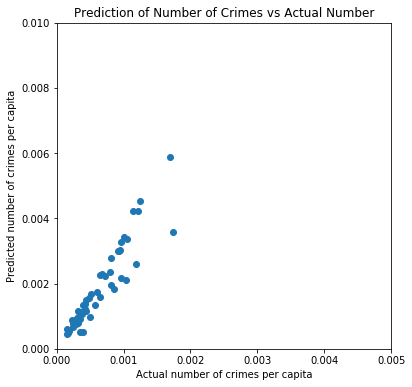

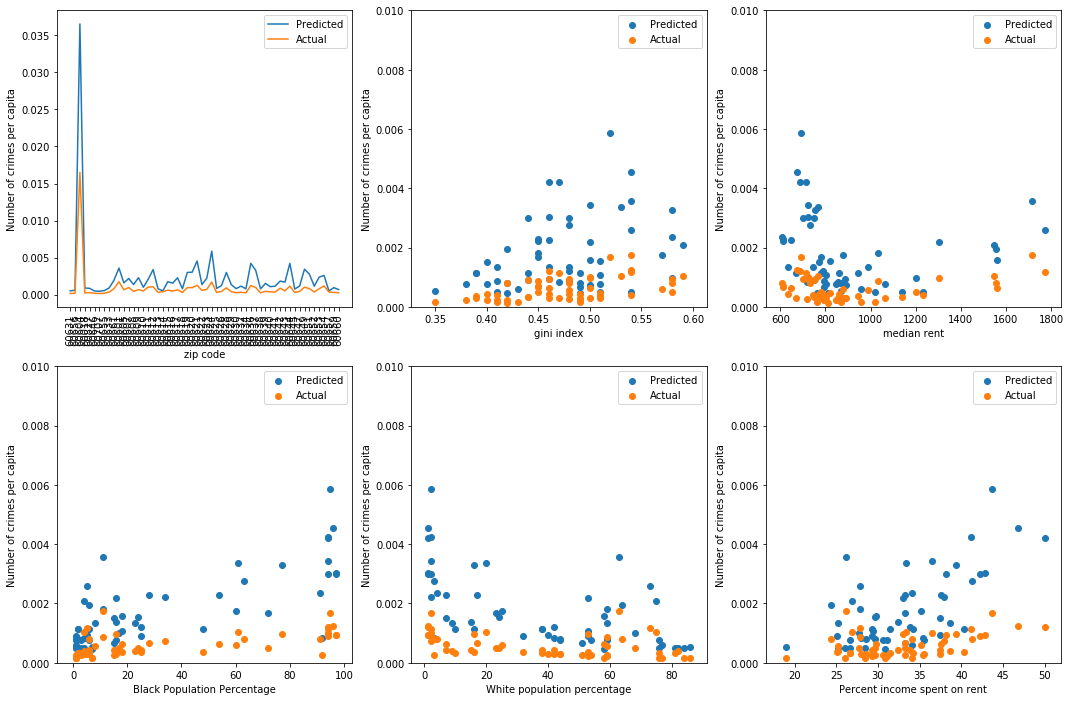

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(6, 6))
df = pd.DataFrame(predict_total_crimes)
x = df['actual_crimes']
y = df['predicted_crimes']
plt.scatter(x,y)    
plt.xlabel('Actual number of crimes per capita')
plt.ylabel('Predicted number of crimes per capita')
plt.title('Prediction of Number of Crimes vs Actual Number')
plt.xlim(0,0.005)
plt.ylim(0,0.01)
plt.figure(figsize=(18, 12))
plt.subplot(231)
x = df['zip']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.plot(x,y1,label='Predicted')
plt.plot(x,y2,label='Actual')
plt.xticks(rotation=90)
plt.xlabel('zip code')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.subplot(232)
x = df['gini_index']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('gini index')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(233)
x = df['median_rent']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('median rent')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(234)
x = df['black_pop_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('Black Population Percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(235)
x = df['white_pop_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('White population percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(236)
x = df['percent_income_spent_on_rent']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('Percent income spent on rent')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)


(0, 0.01)

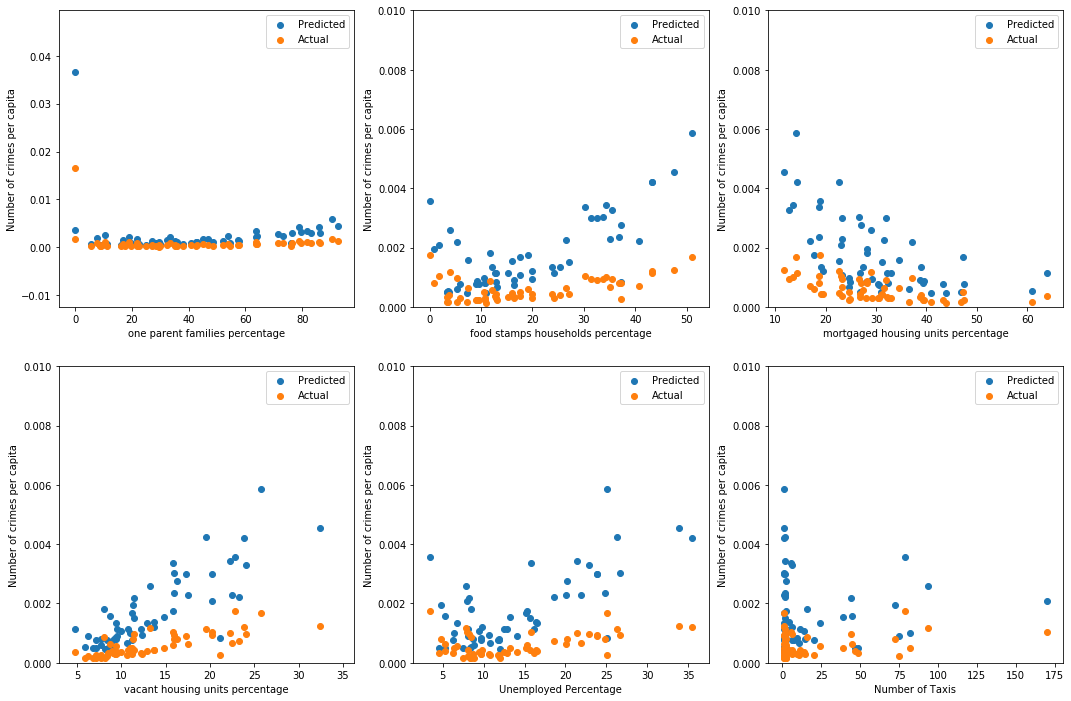

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(predict_total_crimes)
plt.figure(figsize=(18, 12))
plt.subplot(231)
x = df['one_parent_families_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('one parent families percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.subplot(232)
x = df['food_stamps_households_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('food stamps households percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(233)
x = df['mortgaged_housing_units_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('mortgaged housing units percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(234)
x = df['vacant_housing_units_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('vacant housing units percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(235)
x = df['unemployed_percentage']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('Unemployed Percentage')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)
plt.subplot(236)
x = df['num_taxis']
y1 = df['predicted_crimes']
y2 = df['actual_crimes']
plt.scatter(x,y1,label='Predicted')
plt.scatter(x,y2,label='Actual')
plt.xlabel('Number of Taxis')
plt.ylabel('Number of crimes per capita')
plt.legend()
plt.ylim(0,0.01)


In [0]:
%%bigquery --project $project_id predict_total_crimes

SELECT * FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` t1

### Analysis
The predicted number of crimes per capita and the actual number of crimes per capita behave similarly as a function of the features. (As in, their general trends are similar). However, the predicted value tends to be higher than the actual value. This inconsistency may be because the number of crimes is decreasing in Chicago each year, and the ML model is sampled from earlier dates.

The plot below shows the relationship between the total number of crimes and time in Chicago. Indeed, it is visible that the number of crimes appears to be decreasing. With a plot of any given feature on the x-axis, and a group of data from the training period and also from the prediction period on the y-axis, we would expect to see two groups of data. The test set would not be on the hyperplane, and while the training set is on it.

One way around this problem would be to order the dataset and then sample it randomly into 60/20/20 split. We elaborate more on this in the appendix for completeness.

R2 value is considerably high, and this could be because the crimes per capita and features remain relatively stable over five years.


In [0]:
%%bigquery --project $project_id total_crimes_over_time

SELECT COUNT(unique_key) AS num_crimes, EXTRACT(DATE from date) AS actual_date FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` t1 GROUP BY actual_date ORDER BY actual_date

Text(0.5, 1.0, 'Time trends of total crime in Chicago')

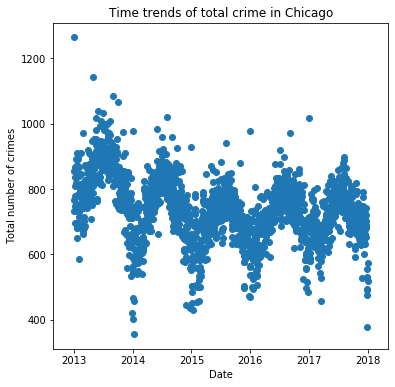

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(6, 6))
df = pd.DataFrame(total_crimes_over_time)
x = df['actual_date']
y = df['num_crimes']
plt.scatter(x,y)
plt.xlabel('Date')
plt.ylabel('Total number of crimes')
plt.title('Time trends of total crime in Chicago')

## Conclusion

1.   Most of the features we looked at were economic factors, and each showed an intuitive correlation to crime. Our prediction for total crimes has minimal error value and R2 value close to one; this is because the change in feature values is stable over a five year period (census data collection), and crime per capita is small in comparison to other figures. 
   
2.   Certain features, such as the number of taxis in the area (grouped by zip code) and ethnicity, may overlap with the area's socioeconomic characteristics. For example, there may be more taxis in wealthier neighborhoods and, similarly, more "ethnic minorities" in less fortunate parts of the city. Thus we can expect that these extra features may not significantly contribute to increasing the accuracy of the prediction.

3.   In the machine learning prediction, predicted values for total crimes per capita are significantly higher than the actual crimes per capita; this can be attributed to the fact that the number of crimes is has been decreasing in Chicago over time. Repartitioning the training data set through random sampling may solve this issue. However, it also may not, if the causes for this decrease are not represented in the set of features (for example, more effective policing.)

4.   We found the negative correlation between the number of taxis in an area and crime to be surprising. More taxi traffic would suggest more population and activity in a community and increased opportunity for unlawful acts. Conversely, minimal taxi traffic would indicate less opportunity for crime. According to the results, however, this was not the case. This result may suggest that in general, crimes are more likely to take place in areas less crowded. 

5.   The tables used in the project were equity joined using geographic features and timestamps. There may exist other ways of joining each data and finding features that may result in different machine learning performances.


##Appendix

Here we show how the decreasing number of crimes over time (leading to overprediction) could be overcome:

In [0]:
%%bigquery --project $project_id 

/*Order by date*/
WITH total AS (SELECT * FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` ORDER BY date),
/*Select training set randomly*/
training AS (SELECT * FROM total WHERE RAND() < 808901/1348169),
/*Subtract training set from total data*/
total_sub_training AS (
SELECT t1.*
FROM total t1 LEFT JOIN training t2  
ON t1.unique_key = t2.unique_key
WHERE t2.unique_key IS NULL),
/*Pick evaluation set*/
eval AS (SELECT * FROM total_sub_training WHERE RAND() < 1.2/2),
/*Get prediction set from leftover*/
predict AS (
SELECT t1.*
FROM total_sub_training t1 LEFT JOIN eval t2  
ON t1.unique_key = t2.unique_key
WHERE t2.unique_key IS NULL)
SELECT (SELECT COUNT(*) FROM total) AS total_tuples, (SELECT COUNT(*) FROM training) AS training_tuples, (SELECT COUNT(*) FROM total_sub_training) AS total_sub_training_tuples, (SELECT COUNT(DISTINCT unique_key) FROM total) AS total_keys, (SELECT COUNT(*) FROM eval) AS eval_tuples, (SELECT COUNT(*) FROM predict) AS predict_tuples

,total_tuples,training_tuples,total_sub_training_tuples,total_keys,eval_tuples,predict_tuples
0,1348169,808147,538362,1348169,324105,409577


Strangely, we can see the total number of tuples in the partitioned tables is higher than the total_tuples in the original table. If we limit the initial table to four entries, we find there may be a technical issue with BigQuery:

In [0]:
%%bigquery --project $project_id 

WITH total AS (SELECT * FROM `cs145-fa19-254601.CrimeStats.census_crime_taxi` WHERE unique_key = 11200805 OR unique_key = 11081808 OR unique_key = 9259320 OR unique_key = 9115098),
training AS (SELECT * FROM total WHERE RAND() < 1/2),
total_sub_training AS (
SELECT a.*
FROM total a LEFT OUTER JOIN training b  
ON a.unique_key = b.unique_key 
WHERE b.unique_key IS NULL
)
(SELECT a.unique_key, 'total' AS type FROM total a) UNION ALL (SELECT a.unique_key, 'training' AS type FROM training a) UNION ALL (SELECT a.unique_key, 'total sub training' AS type FROM total_sub_training a) UNION ALL (SELECT t1.unique_key as unique_key, 'total sub training join training' as type FROM total_sub_training t1,training t2 WHERE t1.unique_key=t2.unique_key) ORDER BY type

,unique_key,type
0,11200805,total
1,9115098,total
2,11081808,total
3,9259320,total
4,9115098,total sub training
5,11200805,total sub training join training
6,11200805,training
7,9115098,training


Semantically, the above query should result in the table being partition into disjoint sets; however, BigQuery does not. During office hours, professor Shiva mentioned the potential causes for the issue might include issues in concurrency over multiple servers due to timeouts.

Upon examination, we later found out that the WITH clause is executed each time that the query is referenced; this causes instances of inconsistent tables. In the future, it would be rewarding to discover a more robust and efficient way of partitioning by random sampling. 